In [1]:
## 4/20/16:  adapt CapFid univstress code (du003nak...) to backtest chapter exhibits
## 4/18/16:  indiv flag added for indiv banks, BHCs in aggregate groups; Cxflg for C18 and C31 groups
## 4/15/16:  USflg added to allow including TotUSx00,x18,x31 groups
## 4/14/16:  modify to allow running indiv banks within tickers... also, set up x00, x18, x31 versions for ad hoc groups
## 4/13/16:  update for htyp, etc... then re-run for book exhibs.

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## lists of states and banks within regional group to analyze:
## state/region:  if none: stlst=[]; if one only: stlst=['FL']; if multiple states aggregated: stlst=['FL','GA','AL']
#stlst = ['FL','GA']
#stlst = ['NV']
#stlst = ['CA']
stlst=[]  # use this if no states selected

## exclusion list:
exlst = []  ## use this as default
#exlst = [2502656,3150447,2129008,2036843,3287660,2819167] # USAA, Chas Schwab, Household (SB & NA), Toyota, Farm Bureau
#exlst = [2193616,665931,1212846]  ## FL,GA exclude: Raymond James, Northern Trust, Monogram Credit Card
if len(exlst)==0:
  exflg = ''
else:
  exflg = 'x'

#########################################################################
## Pick one of the next description lines:  
#irflg = '_NoRates'  ## use this to remove rates from regressions
#irflg = '_NoRate_Big2'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI
#irflg = '_NoRate_Big3'  ## SPECIAL: designates backtest re-run using only "big 3" vars: UE, HPI, CRE
#irflg = '_NoRate_Big4v'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, VIX
#irflg = '_NoRate_Big4c'  ## SPECIAL: designates backtest re-run using only "big 4" vars: UE, HPI, CRE, CE
#irflg = ''  ## use this to keep rates in regressions and use all variables in regressions
irflg = '_Big3' ## use this to keep rates in regressions but limit vars to Big3 only

############################################################
# 12/13/15: new list: brief list of only vars to use in regressions
#   (Note: can be a number other than 3 if desired... like 4 or 5) 
#big3 = ['UE','HPI']  ### list of big3 variables - CRE
big3 = ['UE','HPI','CRE']  ### list of big3 variables
#big3 = ['UE','HPI','CRE','VIX']  ### list of big3 vars + VIX
#big3 = ['UE','HPI','CRE','CE']  ### list of big3 vars + CE
#big3 = ['UE','HPI','CRE','CE','VIX']  ### list of big3 vars + CE + VIX
#big3=[]  ## use this if Big3 not selected

############################################################
## Create ad hoc group of banks here:
## WARNING:  Select small group of unique banks here:
rslst=[]  # IDRSSD list for ad hoc 
#rslst = [598534]  ## Fidelity (GA)
tclst=[]  # ticker list for ad hoc
#tclst = ['CCBG']  ## Capital City (FL)

##########################################################################
##  NOTE:  Large bank exclusions:  Pick one of 3 options:
##  'x00':  Include all banks (do not exclude any)
##  'x18':  Exclude CCAR 18-bank group and their acquired/merged banks
##  'x31':  Exclude CCAR 31-bank group and their acquired/merged banks
xtyp = 'x18'  ## pick 'x00', 'x18', or 'x31' only, (with grpC18, use x00 only)

htyp = ''  # use this for ultcert tickers (to catch acquired banks in history)
#htyp = 'nohist'  # 20160325

## group name: select one line only among choices:
## (note: only one group can be specified, but all groups will be available for further analysis later!)
## (this label will be used to name all output files to make it easy to locate them later)
#grp = 'grp' + 'TotUS_C18C31' + xtyp + exflg + htyp # special code:
grp = 'grp' + 'TotUS' + xtyp + exflg + htyp # use this for TotUS target group
#grp = 'grp' + 'C18' + xtyp + exflg + htyp # use this for C18 target group
#grp = 'grp' + 'C31' + xtyp + exflg + htyp # use this for C31 target group
#grp = 'grp' + ''.join(stlst) + xtyp + exflg + htyp # use this for statelist (1, 2, or 3 states only)
#grp = 'grp' + 'CapFid'+ ''.join(stlst) + xtyp + exflg + htyp # use this for any other grouping (fill in a unique name into blanks)
#grp = 'grp' + 'CapFid' # use this for any other grouping (fill in a unique name into blanks)

USflg = 'Yes'  # 'Yes' means run TotUSx00,x18,x31 groups, 'No' means do not run TotUS groups
Cxflg = 'Yes'  # 'Yes' means run C18x00 and C31x00 groups, 'No' means do not run those groups
indiv = 'No'  # 'Yes' means run indiv banks, 'No' means do not run indiv banks

## flags for var transforms to use: orig, lag, exp
vtyp = 2  # 0: Original vars+CE, no transformations; 1: lags (UE,HPI,CRE,CE 4q lags); 2: Lags & sUE23
qtyp = 4  # 4: rolling 4q NCO rates, 1: 1qtr NCO rates (annualized)

if qtyp == 1:
  rtyp = "1q"
  rskp = 0
  curlst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']
elif qtyp == 4:
  rtyp = "4q"
  rskp = 3
  curlst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
else:
  rskp = 999
  rclst = []  # force error

cbo = ['Orig', 'Lags', 'Lags_sUE2']  # descriptors for vtyp code 
styp = cbo[vtyp]  # selects one of the cbo codes based on vtyp entry.

grporig = grp
grp, styp, irflg

('grpTotUSx18', 'Lags_sUE2', '_Big3')

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

hs['DJ'] = hs['DJ']/1000
cc['DJ'] = cc['DJ']/1000

cc2 = cc.dropna(how='any',axis=1)  # remove any vars that are missing in any ccar year (removes T5y, Prime)
cccol = list(cc2.columns)[3:]
hs2 = hs[['Date']+cccol]
hs2.set_index('Date', drop=True, inplace=True)
hs2 = hs2.ix['2000-01':]
hscol = list(hs2.columns)  # original ccar variables

In [4]:
## Tickers to exclude from aggregates: CCAR 18-bank and 31-bank groups:
c18tic = ['ALLY','AXP','BAC','BBT','BK','C','COF','FITB','GS','JPM','KEY','MS','PNC','RF','STI','STT','USB','WFC']
c31tic = c18tic + ['BMO','BBVA','CFG','CMA','DB','DFS','HSBC','HBAN','MTB','MTU','NTRS','SAN','ZION']

In [5]:
#########################################################
## section to download CE and state CE & UE variables
#########################################################

In [6]:
## prepare to gather nominal GDP from FRED database:
start = pd.datetime(1976,1,1)
end = pd.datetime(2020,3,31)  # NOTE:  adjust this if processing 2017 or later quarters

In [7]:
if len(stlst) == 0:
  print("No states selected.")
else:
  print("OK to proceed.")

No states selected.


In [8]:
## process only if len(stlst)>0:
uestq = []
if len(stlst) > 0:
  uelst = [s + 'UR' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLUR' = FL unemp rate 
  lflst = [s + 'LF' for s in stlst]  ## codes in FRED database: 'FLLF' = FL labor force
  ## NOTE:  use labor force values as weightings for regional aggregates of state UE rates
  uest = web.DataReader(uelst+lflst,'fred',start,end)  ## download data in uest dataframe
  uest['UE_'+''.join(stlst)] = uest.apply(lambda x:np.average(x[[z+'UR' for z in stlst]],\
                                           weights=x[[z+'LF' for z in stlst]]),axis=1)
  uestq = uest.resample('Q').mean()

if len(uestq)>0:
  print(uestq.head(2))
else:
  print('No state UE')

No state UE


In [9]:
celst = [] # CE codes for FRED database
telst = [] # TotEmployment codes for FRED database

if len(stlst)>0: celst = [s + 'CONS' for s in stlst]  ## codes for unemployment rate in FRED database: 'FLCE' = FL constr emp
celst = ['USCONS'] + celst
if len(stlst)>0: telst = [s + 'NA' for s in stlst]  ## FLNA is Florida total non-farm employment
telst = ['PAYEMS'] + telst
cest = web.DataReader(celst+telst,'fred',start,end)  ## download data in uest dataframe
if len(stlst)>0:
  cest[''.join(stlst)+'CONS'] = cest.apply(lambda x:np.sum(x[[z+'CONS' for z in stlst]]),axis=1)
  cest[''.join(stlst)+'NA'] = cest.apply(lambda x:np.sum(x[[z+'NA' for z in stlst]]),axis=1)
cest[['USCONS','PAYEMS']] = cest[['USCONS','PAYEMS']].astype('float')
cestq = cest.resample('Q').mean()
cestq.ix['2014']

USCONS         PAYEMS
DATE                                  
2014-03-31  6010.000000  137743.333333
2014-06-30  6108.666667  138547.000000
2014-09-30  6210.000000  139297.333333
2014-12-31  6274.666667  140101.333333

In [10]:
cestq['CE'] = cestq['USCONS']*100 / cestq['PAYEMS']
if len(stlst)>0: cestq['CE_'+''.join(stlst)] = cestq[''.join(stlst)+'CONS']*100 / cestq[''.join(stlst)+'NA']
cestq.tail()

USCONS         PAYEMS        CE
DATE                                            
2019-03-31  7439.333333  150183.666667  4.953490
2019-06-30  7481.333333  150609.333333  4.967377
2019-09-30  7512.000000  151160.333333  4.969558
2019-12-31  7545.000000  151788.333333  4.970738
2020-03-31  7612.666667  152085.666667  5.005512

In [11]:
if 'CE' not in list(hs2.columns): 
  hs2 = hs2.merge(cestq[['CE']],how='left',left_index=True, right_index=True)
  if len(stlst)>0: 
    hs2 = hs2.merge(cestq[['CE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
    hs2 = hs2.merge(uestq[['UE_'+''.join(stlst)]],how='left',left_index=True, right_index=True)
hs2.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  Mort      DJ  \
Date                                                                           
2018-12-31    1.1    2.9   2.8   4.2  3.8  1.5  2.3   3.0  4.8   4.8  25.725   
2019-03-31    3.1    3.9   4.5   4.9  3.9  0.9  2.4   2.7  4.5   4.4  29.194   
2019-06-30    2.0    4.7   1.5   3.9  3.6  2.9  2.3   2.4  4.0   4.0  30.244   
2019-09-30    2.1    3.8   2.9   4.5  3.6  1.8  2.0   1.8  3.4   3.7  30.442   
2019-12-31    2.0    4.0   2.1   4.5  3.5  2.6  1.6   1.8  3.3   3.7  33.035   

              HPI    CRE   VIX        CE  
Date                                      
2018-12-31  205.0  280.0  36.1  4.933455  
2019-03-31  206.0  289.0  25.5  4.953490  
2019-06-30  208.0  303.0  20.6  4.967377  
2019-09-30  210.0  311.0  24.6  4.969558  
2019-12-31  212.0  316.0  20.6  4.970738

In [12]:
### remove all interest rate variables: (They interfere with scenario forecasts.)
xvr = ['Mort','T3m','T5y','T10y','Prime','BBB'] ## xvr: interest rate CCAR vars to exclude from regressions

### ALWAYS remove int rates for this set of regressions for CE ,CE_st and UE_st variables!!!!
cccol = [x for x in cccol if x not in xvr]  ## removes interest rate vars from cccol (ccar var columns)
cccol

['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'DJ', 'HPI', 'CRE', 'VIX']

In [13]:
## 3-var models:
## hs2, cc2 have removed T5y and Prime since those are not in CCAR 2012 or 2013 variables
hsy = hs2.copy()
hsz = hs2.copy()
hsz['Intercept'] = 1.0
hsz.reset_index(drop=False,inplace=True)
ccs = cc2.copy()
ccs.sort_index(by=['Scen','Date'],inplace=True)
ccs['Intercept'] = 1.0
svlst = [x for x in list(hs2.columns) if x not in hscol]
curlst = svlst
topn = 1  # number of final models to review (use topn=1 for production)
topx = 2  # number of 2-var pairs to allow in final 3 for 3-var models
curlst

['CE']

In [14]:
### build 3-var models:

In [15]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [16]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'], as_index=False)
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [17]:
# function to select topn models for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3a.index.names = ['rci','v1i','v2i','i']
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [18]:
df3b.to_csv(grp+"_3var_stvar_params.csv")

In [19]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [20]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 3-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 4-var combo
df4a.index.names = ['rci','v1i','v2i','v3i','i']
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 4-var models
df4b.index = np.arange(len(df4b))

In [21]:
df4b.to_csv(grp+"_4var_stvar_params.csv")
df4b

rc  v1        r1  v2        r2   v3        r3   v4       r4      Int  \
0  CE  UE  0.448494  DJ  0.800205  HPI  0.919301  CPI  0.92091  6.01004   

         c1       c2        c3        c4  
0 -0.221279 -0.07056  0.008054  0.011023

In [22]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs[rc] = p_tot


In [23]:
ccp = ccs[ccs.Scen.isin(['Bas','Sev'])].copy()
ccp['yrscen'] = ccp.apply(lambda x: str(x['CCAR'])[-2:]+'_'+x['Scen'],axis=1)
ccp.sort_index(by=['CCAR','Scen','Date'],inplace=True)
ccp.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T10y  BBB  \
348  2020  Sev 2022-12-31    4.7    6.1   2.1   3.6  8.8  1.8  0.1   2.1  4.1   
349  2020  Sev 2023-03-31    4.7    6.1   2.1   3.5  8.5  1.7  0.1   2.2  3.7   

     Mort      DJ    HPI    CRE   VIX  Intercept        CE  yrscen  
348   3.9  28.905  158.0  208.0  23.0        1.0  3.315658  20_Sev  
349   3.8  31.454  161.0  211.0  20.0        1.0  3.225244  20_Sev

In [24]:
svlst

['CE']

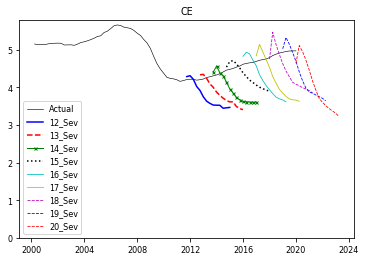

In [25]:
i = 0  ## enter 0, 1, or 2 only (for 3 items in svlst)
gr = pd.DataFrame(hsy[svlst[i]])
gr.rename(columns={svlst[i]:'Actual'},inplace=True)
cp3 = ccp[['yrscen','Date',svlst[i]]]
cp3 = cp3.pivot('Date','yrscen',svlst[i])

gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)
xa = list(gr3.index)

plt.rcParams.update({'font.size': 8})
plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
#plt.plot(xa, gr3['12_Bas'],c='b',ls=':',lw=1.3,label="12_Bas")
plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
#plt.plot(xa, gr3['13_Bas'],c='r',ls=':',lw=1.3,label="13_Bas")
plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
#plt.plot(xa, gr3['14_Bas'],c='g',ls=':',lw=1.3,label="14_Bas")
plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
#plt.plot(xa, gr3['15_Bas'],c='k',ls=':',lw=1.3,label="15_Bas")
plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
plt.plot(xa, gr3['19_Sev'],c='b',ls='--',lw=.8,label="19_Sev")
plt.plot(xa, gr3['20_Sev'],c='r',ls='--',lw=.8,label="20_Sev")
plt.title(svlst[i])
plt.ylim(bottom=0)
if svlst[i][0:2] == 'CE':
  lc = 3
else:
  lc = 2
plt.legend(loc=lc) # 2 (UE) or 3 (CE)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [26]:
svlst2 = svlst + ['UE']
svlst2.sort()
svlst2

['CE', 'UE']

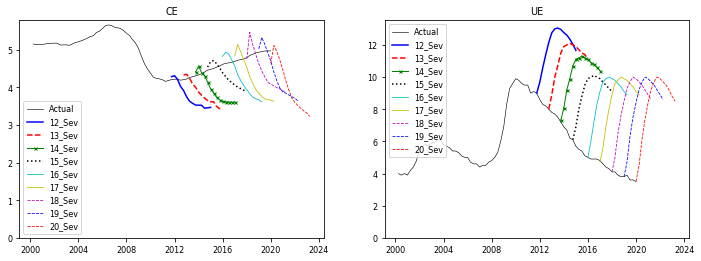

In [27]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=0  ## 0 or 2 only
for i in np.arange(2):
  plt.subplot(1, 2, i+1)
  gr = pd.DataFrame(hsy[svlst2[i+j]])
  gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
  cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
  cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

  gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

  plt.rcParams.update({'font.size': 8})
  plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
  plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
  plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
  plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
  plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
  plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
  plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
  plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
  plt.plot(xa, gr3['19_Sev'],c='b',ls='--',lw=.8,label="19_Sev")
  plt.plot(xa, gr3['20_Sev'],c='r',ls='--',lw=.8,label="20_Sev")
  plt.title(svlst2[i+j])
  plt.legend(loc=0)
  plt.ylim(bottom=0)

plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
plt.show()

In [28]:
"Var"+svlst2[i+j]+'_4var.png',

('VarUE_4var.png',)

In [29]:
xa = list(gr3.index)

## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )

j=2  ## 0 or 2 only
if len(svlst2)==4:
  for i in np.arange(2):
    plt.subplot(1, 2, i+1)
    gr = pd.DataFrame(hsy[svlst2[i+j]])
    gr.rename(columns={svlst2[i+j]:'Actual'},inplace=True)
    cp3 = ccp[['yrscen','Date',svlst2[i+j]]]
    cp3 = cp3.pivot('Date','yrscen',svlst2[i+j])

    gr3 = gr.merge(cp3,how='outer',left_index=True, right_index=True)

    plt.rcParams.update({'font.size': 8})
    plt.plot(xa, gr3['Actual'],c='k',lw=.6,label="Actual")
    plt.plot(xa, gr3['12_Sev'],c='b',ls='-',lw=1.5,label="12_Sev")
    plt.plot(xa, gr3['13_Sev'],c='r',ls='--',lw=1.5,label="13_Sev")
    plt.plot(xa, gr3['14_Sev'],c='g',ls='-',lw=1,marker='x',ms=3,label="14_Sev")
    plt.plot(xa, gr3['15_Sev'],c='k',ls=':',lw=1.5,label="15_Sev")
    plt.plot(xa, gr3['16_Sev'],c='c',ls='-',lw=.8,label="16_Sev")
    plt.plot(xa, gr3['17_Sev'],c='y',ls='-',lw=.8,label="17_Sev")
    plt.plot(xa, gr3['18_Sev'],c='m',ls='--',lw=.8,label="18_Sev")
    plt.plot(xa, gr3['19_Sev'],c='b',ls='--',lw=.8,label="19_Sev")
    plt.plot(xa, gr3['20_Sev'],c='r',ls='--',lw=.8,label="20_Sev")
    plt.title(svlst2[i+j])
    plt.legend(loc=0)
    plt.ylim(bottom=0)

if len(svlst2)== 4:
  plt.savefig("Var"+svlst2[i+j]+'_4var.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('No output...')

No output...


<Figure size 864x288 with 0 Axes>

In [30]:
stcol = [x for x in list(hs2.columns) if x not in list(hs.columns)]  ## list of new variables to process
stcol

['CE']

In [31]:
## add new state and CE columns to original history variable table ('hs'), call it hs3
if len(stcol)>0:
  hs3 = hs.copy()
  hs3.set_index('Date',drop=True,inplace=True)
  hs3 = hs3.ix['2000':]
  hs3 = hs3.merge(hs2[stcol],how='left',left_index=True,right_index=True)

hs3.head(2)

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
Date                                                                        
2000-03-31    1.5    4.2   7.9  11.5  4.0  4.0  5.5  6.6   6.7  8.3   8.3   
2000-06-30    7.5   10.2   4.5   6.4  3.9  3.2  5.7  6.5   6.4  8.6   8.3   

            Prime      DJ    HPI    CRE   VIX        CE  
Date                                                     
2000-03-31    8.7  14.296  102.0  127.0  27.0  5.154105  
2000-06-30    9.2  13.619  105.0  126.0  33.5  5.136168

In [32]:
## add new state and CE columns to original ccar variable table ('cc'), call it cc3:
if len(stcol)>0:
  cc3 = cc.copy()
  cc3.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  cc3 = cc3.merge(ccs[['CCAR','Scen','Date']+stcol],how='left',on=['CCAR','Scen','Date'])

cc3.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   

    BBB  Mort  Prime        DJ     HPI     CRE    VIX        CE  
0  4.90  4.20    NaN  11.67700  132.00  177.00  48.00  4.286421  
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97  4.280258

In [33]:
hs3.to_csv(grp+'_histvars.csv')
cc3.to_csv(grp+'_ccarvars.csv')

In [34]:
## end of state variable (and CE) processing... move onto gathering bank data

In [35]:
## gather Call Rpt data for requested groups:

In [36]:
## process Call Rpt data for requested banks:
## rk table will be used to find identifiers (and associated acquired banks for BHCs)
if htyp == 'nohist':
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_nohist202003.csv", index_col=0)  # 201612 nohist version
else:
  rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult202003.csv", index_col=0)  # fixed 3 dup tickers (FBMS,FCBC,RBCAA)

rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
htyp

''

In [37]:
rk['C18'] = 'No'
rk['C31'] = 'No'
#c18tic
rk.loc[rk.Ticker.isin(c18tic), 'C18']='C18'
rk.loc[rk.Ticker.isin(c31tic), 'C31']='C31'

In [38]:
b18 = set(list(rk[rk['C18']=='C18']['IDRSSD']))  ## C18 banks 
b31 = set(list(rk[rk['C31']=='C31']['IDRSSD']))  ## C31 banks 

len(b18), len(b31), len(exlst) # 460, 622, 0

(460, 622, 0)

In [39]:
############ CAUTION
############ CAUTION

In [40]:
## CAUTION:  DO NOT RE-RUN THIS CELL if it was run earlier in session (wastes a lot of time)
## read Call Report extract file for all banks:
dg2 = pd.read_csv("df2_2001_202003.csv")
dg2['AsOf'] = pd.to_datetime(dg2['AsOf'])

fcol = dg2.columns[5:]  ## get listing of numeric fields, then...
dg2[fcol] = dg2[fcol].astype(float)  ### CRITICAL to convert numeric data to FLOAT!!! (since some are ints)

In [41]:
dcol = list(dg2)[5:]  ## data column names
dcol[0:5]

['Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO']

In [42]:
## grpTotUSx00:
px00 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px00 = dg2[['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px00n = dg2[['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px00n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px00 = pd.concat([px00n,px00], join='inner', axis=1)
  px00 = px00.reset_index(drop=False)
  px00['IDRSSD'] = 0
  px00['Grp'] = 'grp' + 'TotUS' + 'x00' + htyp
  px00 = px00[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px00), 'grp' + 'TotUS' + 'x00' + htyp

(77, 'grpTotUSx00')

In [43]:
## grpTotUSx18:
px18 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px18 = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px18n = dg2[~dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px18 = pd.concat([px18n,px18], join='inner', axis=1)
  px18 = px18.reset_index(drop=False)
  px18['IDRSSD'] = 0
  px18['Grp'] = 'grp' + 'TotUS' + 'x18' + htyp
  px18 = px18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px18), 'grp' + 'TotUS' + 'x18' + htyp

(77, 'grpTotUSx18')

In [44]:
## grpTotUSx31:
px31 = []
if ('TotUS' in grp)|(USflg == 'Yes'):
  px31 = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  px31n = dg2[~dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  px31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  px31 = pd.concat([px31n,px31], join='inner', axis=1)
  px31 = px31.reset_index(drop=False)
  px31['IDRSSD'] = 0
  px31['Grp'] = 'grp' + 'TotUS' + 'x31' + htyp
  px31 = px31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(px31), 'grp' + 'TotUS' + 'x31' + htyp

(77, 'grpTotUSx31')

In [45]:
#C18 processing:
pcx18=[]
if ('C18' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx18 = dg2[dg2['IDRSSD'].isin(b18)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx18n = dg2[dg2['IDRSSD'].isin(b18)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx18n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx18 = pd.concat([pcx18n,pcx18], join='inner', axis=1)
  pcx18 = pcx18.reset_index(drop=False)
  pcx18['IDRSSD'] = 0
  pcx18['Grp'] = 'grpC18x00'
  pcx18 = pcx18[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx18)

77

In [46]:
# C31 processing:
pcx31=[]
if ('C31' in grp)|(Cxflg=='Yes'):
  clst=[]
  xlst = []

  pcx31 = dg2[dg2['IDRSSD'].isin(b31)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pcx31n = dg2[dg2['IDRSSD'].isin(b31)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pcx31n.rename(columns={'eTotAst':'nbr'},inplace=True)
  pcx31 = pd.concat([pcx31n,pcx31], join='inner', axis=1)
  pcx31 = pcx31.reset_index(drop=False)
  pcx31['IDRSSD'] = 0
  pcx31['Grp'] = 'grpC31x00'
  pcx31 = pcx31[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pcx31)

77

In [47]:
## state level aggregates: # 20160414:  run x00
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
pxstx00 = []
xt = ''
if len(stlst)>0:
  xt = 'x00'
  stx = []
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  if len(stx)==0: strs = [x for x in strs]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx00 = pxst.copy()

len(pxstx00)

0

In [48]:
## state level aggregates: # 20160414:  run x18x
pxstx18x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
xt=''
if (len(stlst)>0)&(exflg=='x'):
  xt = 'x18'
  stx = list(b18) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18x = pxst.copy()

len(pxstx18x)

0

In [49]:
## state level aggregates: # 20160414:  run x18
pxstx18=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
xt=''
if (len(stlst)>0):
  xt = 'x18'
  stx = list(b18) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt  + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx18 = pxst.copy()

len(pxstx18)

0

In [50]:
## state level aggregates: # 20160414:  run x00, x18, x31
pxstx31=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
xt=''
if len(stlst)>0:
  xt = 'x31'
  stx = list(b31) + exlst
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + exflg + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx31 = pxst.copy()

len(pxstx31), 'grp' + ''.join(stlst) + xt + exflg, len(stx), len(strs)

(0, 'grp', 0, 0)

In [51]:
## state level aggregates: # 20160414:  run x31x
pxstx31x=[]
stx = []  # state-level exclude list
strs = []  # state-level include list
pxst = []
xt=''
if len(stlst)>0:
  xt = 'x31'
  stx = list(b31) 
  strs=list(rk[rk['xState'].isin(stlst)]['IDRSSD'])  ## add state-level included banks
  if len(stx)>0: strs = [x for x in strs if x not in stx]  ### remove state-level excluded banks
  pxst = dg2[dg2['IDRSSD'].isin(strs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxstn = dg2[dg2['IDRSSD'].isin(strs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxstn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxst = pd.concat([pxstn,pxst], join='inner', axis=1)
  pxst = pxst.reset_index(drop=False)
  pxst['IDRSSD'] = 0
  pxst['Grp'] = 'grp' + ''.join(stlst) + xt + htyp
  pxst = pxst[['AsOf','Grp','IDRSSD','nbr']+dcol]
  pxstx31x = pxst.copy()

len(pxstx31x), 'grp' + ''.join(stlst) + xt + htyp, len(stx), len(strs)

(0, 'grp', 0, 0)

In [52]:
if len(pxstx18)> 0: 
  pxstx18.head(2)
else:
  print("Nothing to do")

Nothing to do


In [53]:
len(stx), exlst, grp

(0, [], 'grpTotUSx18')

In [54]:
#prd='eTotLn'
#if len(stlst)>0:
#  #df.iloc[df.groupby(['Mt']).apply(lambda x: x['count'].idxmax())]
#  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
#  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)
#  #dgp['Rank'] = dgp.groupby(['IDRSSD'])[prd].rank(ascending=False)
#
#  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
#  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
#  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
#  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
#  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")
#  dgp5[0:20]3
#
#if len(stlst)==0:
#  print('Nothing to do')

In [55]:
prd='eTotLn'
dgp5=[]

if len(stlst)>0:
  dgp = dg2[(dg2[prd]>0)&(dg2.State.isin(stlst))][['IDRSSD','Name','AsOf',prd]]
  dgp.sort_index(by=['IDRSSD',prd],ascending=[True,False],inplace=True)

  dgp.sort_index(by=['IDRSSD','AsOf'],inplace=True)
  dgp5 = dgp.ix[dgp.groupby(['IDRSSD']).apply(lambda x: x[prd].idxmax())]
  dgp5 = dgp5.merge(rk[['IDRSSD','Ticker','C18','C31','xState','xCert','xAsOf']],how='left',on='IDRSSD')
  dgp5.sort_index(by=[prd],ascending=False,inplace=True)
  dgp5.to_csv(grp+"_"+prd+"_maxbal.csv")

if len(dgp5)>20: dpg5=dgp5[0:20]
    
dgp5

[]

In [56]:
# process requested tickers and IDRSSDs:
pxbk = []
if (len(tclst)>0)&(indiv=='Yes'):
  bkrs=rslst+list(rk[rk['Ticker'].isin(tclst)]['IDRSSD'])
  bknm=list(rk[rk['IDRSSD'].isin(bkrs)]['xName'])
  pxbk = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
  pxbkn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
  pxbkn.rename(columns={'eTotAst':'nbr'},inplace=True)
  pxbk = pd.concat([pxbkn,pxbk], join='inner', axis=1)
  pxbk = pxbk.reset_index(drop=False)
  pxbk['IDRSSD'] = 0
  pxbk['Grp'] = grp
  pxbk = pxbk[['AsOf','Grp','IDRSSD','nbr']+dcol]

len(pxbk), grp

(0, 'grpTotUSx18')

In [57]:
# rslst processing:
pxri = []
if (len(rslst)>0)&(indiv=='Yes'):
  for i in np.arange(len(rslst)):
    bknm=rk[rk['IDRSSD']==rslst[i]]['xName']
    pxrj = dg2[dg2['IDRSSD']==rslst[i]][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxrjn = dg2[dg2['IDRSSD']==rslst[i]][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxrjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxrj = pd.concat([pxrjn,pxrj], join='inner', axis=1)
    pxrj = pxrj.reset_index(drop=False)
    pxrj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
    pxrj['IDRSSD'] = rslst[i]
    pxrj = pxrj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxri = pxrj.copy()
    else:
      pxri = pd.concat([pxri,pxrj],ignore_index=True)

if len(rslst)>0:
  len(pxri), ''.join([x[0:3] for x in list(bknm)[0].split()]) + str(i)
else:
  print('Nothing to do')

Nothing to do


In [58]:
# tclst processing:  ## 20160505: handles multiple tickers in tclst!!
pxci = []
if (len(tclst)>0)&(indiv=='Yes'):
  # create dict for ParRSSD:
  tcd = dict([(i, x) for i, x in zip(rk[rk.Ticker.isin(tclst)].Ticker, rk.ParRSSD)])
  for i in np.arange(len(tclst)):
    bkrs=list(rk[rk['Ticker'].isin([tclst[i]])]['IDRSSD'])
    bknm=(rk[rk['IDRSSD']==bkrs[i]]['Parent'])
    pxcj = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf']+dcol].groupby(by=['AsOf']).sum()
    pxcjn = dg2[dg2['IDRSSD'].isin(bkrs)][['AsOf','eTotAst']].groupby(by=['AsOf']).count()
    pxcjn.rename(columns={'eTotAst':'nbr'},inplace=True)
    pxcj = pd.concat([pxcjn,pxcj], join='inner', axis=1)
    pxcj = pxcj.reset_index(drop=False)
    pxcj['IDRSSD'] = tcd[tclst[i]]
    pxcj['Grp'] = 'grp' + ''.join([x[0:3] for x in list(bknm)[0].split()[0:3]]) + str(i)
    pxcj = pxcj[['AsOf','Grp','IDRSSD','nbr']+dcol]
    if i==0:
      pxci = pxcj.copy()
    else:
      pxci = pd.concat([pxci,pxcj],ignore_index=True)

len(pxci)

0

In [59]:
pxlst = [px00,px18,px31,pcx18,pcx31,pxstx00,pxstx18,pxstx18x,pxstx31,pxstx31x,pxbk,pxri,pxci]
pxz = pd.concat([x for x in pxlst if len(x)>0])
gpxz = list(pxz[['Grp','AsOf']].groupby('Grp').count().index)
len(pxz), gpxz

(385, ['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31'])

In [60]:
pxz[['Grp','nbr']].groupby('Grp').count()

nbr
Grp             
grpC18x00     77
grpC31x00     77
grpTotUSx00   77
grpTotUSx18   77
grpTotUSx31   77

In [61]:
pxz2 = pxz[['Grp','nbr']].groupby('Grp').mean()
pxz2

nbr
Grp                     
grpC18x00     124.142857
grpC31x00     180.116883
grpTotUSx00  7177.376623
grpTotUSx18  7053.233766
grpTotUSx31  6997.259740

In [62]:
grplst = list(pxz2.index)
grplst

['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31']

In [63]:
## set up processing tables for calcs:
df3 = pxz.copy()  # set up for calc processing using old table names
df3.sort_index(by=['Grp','IDRSSD','AsOf'],inplace=True)  ## added 12/24/15

df3['mn'] = df3['AsOf'].map(lambda x: x.month)  ## add separate month col to ease calcs converting YTDs to qtrly vals

df3a = df3[['Grp','IDRSSD','AsOf','mn']]  # table used to run calcs
df3z = df3[['Grp','IDRSSD','AsOf']]  # table to hold calc results

In [64]:
dct = { 3 : 0, 6 : 1/2 , 9 : 2/3, 12 : 3/4 }

# fn to adjust 1st row of each bank... 
# modified to use dict "dct" to speed processing:
def qa(x):
  if x['mn'] == 3: return 0
  if pd.isnull(x['x_1']):
    return dct[x['mn']] * x['x']
  else: 
    return x['x_1']

def q_calc(xi, xc):
  # calc Call Data into quarterly values from YTD values
  df3a['x'] = df3[xi]
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xi].shift(1)
  df3a['x_1'] = df3a.apply(qa, axis=1)
  df3a['xq'] = df3a['x'] - df3a['x_1']
  df3z[xc] = df3a['xq']
  return

In [65]:
q_calc('isNetInc', 'qNetInc')
q_calc('iiNetII', 'qNetII')
q_calc('isProv', 'qProv')
q_calc('isTotNII', 'qNonII')
q_calc('isTotNIE', 'qNonIE')
q_calc('isOREOgl', 'qOREOgl')    # 20160501
q_calc('isIntangExp', 'qIntangExp')

df3z['qRev'] = df3z['qNetII'] + df3z['qNonII']
df3z['qCashExp'] = df3z['qNonIE'] - df3z['qIntangExp']

q_calc('iiTotII', 'qiTotII')  # 20160320
q_calc('iiTotLn', 'qiTotLn')
q_calc('iiRE', 'qiRE')
q_calc('iiCI', 'qiCI')
q_calc('iiCard', 'qiCard')
q_calc('iiOthCsmr', 'qiOthCsmr')
q_calc('iiLeas','qiLeas')

df3z['qiTotLnLs'] = df3z['qiTotLn']+df3z['qiLeas']  #  20160320
df3z['qiOthLnLs'] = df3z['qiTotLnLs'] - df3z['qiRE'] - df3z['qiCI'] - df3z['qiCard'] - df3z['qiOthCsmr']  # 20160320

q_calc('iiDFIB', 'qiDFIB')
q_calc('iiTreas', 'qiTreas')
q_calc('iiMBS', 'qiMBS')
q_calc('iiOSec', 'qiOSec')
q_calc('iiFFS', 'qiFFS')
q_calc('iiOAstIB','qiOAstIB') # 20160320
q_calc('iiTotSec','qiTotSec') # 20160320
#df3z['qiTotSec'] = df3z['qiTreas'] + df3z['qiMBS'] + df3z['qiOSec']  # 20160320

q_calc('ieTotIE', 'qeTotIE') # 20160320
q_calc('ieNOW', 'qeNOW')
q_calc('ieSav', 'qeSav')
q_calc('ieCDun', 'qeCDun')
q_calc('ieCDov', 'qeCDov')
q_calc('ieFFP', 'qeFFP')
q_calc('ieFDepIB', 'qeFDepIB') ## 20160320
q_calc('ieDepIB', 'qeDepIB') ## 20160320

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ieOthBorr'] + df3['ieNote']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ieOthBorr'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ieNote'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qeBorr'] = df3a['xq']

q_calc('ieOLbIB','qeOLbIB') # 20160320

q_calc('ncoTotLn', 'qncTotLn')
q_calc('ncoCx', 'qncCx')
q_calc('ncoSfRev', 'qncSfRev')
q_calc('ncoSfTD', 'qncSfTD')
q_calc('ncoMult', 'qncMult')
q_calc('ncoCRE', 'qncCRE')
q_calc('ncoCIdom', 'qncCIdom')
q_calc('ncoCIfor', 'qncCIfor')
q_calc('ncoCard', 'qncCard')

# special code to handle 2 cols to be combined into one:
df3a['x'] = df3['ncoAuto'] + df3['ncoOthCsmr']
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['ncoAuto'].shift(1) + df3.groupby(['Grp','IDRSSD'])['ncoOthCsmr'].shift(1)
df3a['x_1'] = df3a.apply(qa, axis=1)
df3a['xq'] = df3a['x'] - df3a['x_1']
df3z['qncOthCsmr'] = df3a['xq']

df3z['qncCREtot'] = df3z['qncCx'] + df3z['qncMult'] + df3z['qncCRE']  # to match CCAR results categories
#df3['eCREtot'] = df3['eCx'] + df3['eMult'] + df3['eCRE']  # to match CCAR results categories

In [66]:
def y_calc(xn, xd, xc):  # quarterly yield calc (annualized):
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3z[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*400 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def r_calc(xn, xd, xc):  # rolling 4q yield calc:
  # calc rolling 4q items: yields, rates, nco rates
  df3a['x'] = df3z.groupby(['Grp','IDRSSD'])[xn].apply(lambda x:x.rolling(4, min_periods=4).sum())
  df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])[xd].apply(lambda x:x.rolling(4, min_periods=4).mean())
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

def qn_calc(xn, xd, xc):  # quarterly non-accrual ratio calc:
  # calc quarterly yield/rate items: yields, rates, nco rates
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [67]:
y_calc('qNetII', 'aEarnAst', 'qyNetII') # 20160329
y_calc('qiTotII', 'aEarnAst', 'qyTotII') # 20160329
y_calc('qiTotLn', 'aTotLn', 'qyTotLn')
y_calc('qiRE', 'aTotRE', 'qyRE')
y_calc('qiCI', 'aCI', 'qyCI')
y_calc('qiCard', 'aCard', 'qyCard')
y_calc('qiOthCsmr', 'aOthCsmr', 'qyOthCsmr')
y_calc('qiOthLnLs','aOthLnLs','qyOthLnLs') # 20160320

y_calc('qiDFIB', 'aDFIB', 'qyDFIB')
y_calc('qiTreas', 'aTreas', 'qyTreas')
y_calc('qiMBS', 'aMBS', 'qyMBS')
y_calc('qiOSec', 'aOSec', 'qyOthSec')
y_calc('qiFFS', 'aFFS', 'qyFFS')
y_calc('qiOAstIB','aOAstIB','qyOAstIB') # 20160320
y_calc('qiTotLnLs', 'aTotLnLs', 'qyTotLnLs')
y_calc('qiTotSec', 'aTotSec', 'qyTotSec')
y_calc('qiOAstIB', 'aOAstIB', 'qyOAstIB')

y_calc('qeTotIE', 'aEarnAst', 'qrTotIE') # 20160329
y_calc('qeNOW', 'aNOW', 'qrNOW')
y_calc('qeSav', 'aSav', 'qrSav')
y_calc('qeCDun', 'aCDun', 'qrCDun')
y_calc('qeCDov', 'aCDov', 'qrCDov')
y_calc('qeFFP', 'aFFP', 'qrFFP')
y_calc('qeBorr', 'aBorr', 'qrBorr')
y_calc('qeOLbIB','aOLbIB','qrOLbIB') # 20160320)

y_calc('qeDepIB', 'aDepIB', 'qrDepIB')
y_calc('qeFDepIB','aFDepIB','qrFDepIB') # 20160320

r_calc('qncTotLn','eTotLn','rcTotLn')
r_calc('qncCx','eCx','rcCx')
r_calc('qncSfRev','eSfRev','rcSfRev')
r_calc('qncSfTD','eSfTD','rcSfTD')  # 6/10/15, uses new eSfTD item

r_calc('qncMult','eMult','rcMult')
r_calc('qncCRE','eCRE','rcCRE')
r_calc('qncCREtot','eCREtot','rcCREtot')
r_calc('qncCIdom','eCIdom','rcCIdom')
r_calc('qncCIfor','eCIfor','rcCIfor')
r_calc('qncCard','aCard','rcCard')
r_calc('qncOthCsmr','aOthCsmr','rcOthCsmr')  

y_calc('qncTotLn','eTotLn','qcTotLn')
y_calc('qncCx','eCx','qcCx')
y_calc('qncSfRev','eSfRev','qcSfRev')
y_calc('qncSfTD','eSfTD','qcSfTD')  # added 6/10/15

y_calc('qncMult','eMult','qcMult')
y_calc('qncCRE','eCRE','qcCRE')
y_calc('qncCREtot','eCREtot','qcCREtot')
y_calc('qncCIdom','eCIdom','qcCIdom')
y_calc('qncCIfor','eCIfor','qcCIfor')
y_calc('qncCard','aCard','qcCard')
y_calc('qncOthCsmr','aOthCsmr','qcOthCsmr')  

qn_calc('nTotLn','eTotLn','qnTotLn')
qn_calc('nCx','eCx','qnCx')
qn_calc('nSfRev','eSfRev','qnSfRev')
qn_calc('nSfTD','eSfTD','qnSfTD')  # added 6/10/15 using new eSfTD item

qn_calc('nMult','eMult','qnMult')
qn_calc('nCRE','eCRE','qnCRE')
qn_calc('nCIdom','eCIdom','qnCIdom')
qn_calc('nCIfor','eCIfor','qnCIfor')
qn_calc('nCard','aCard','qnCard')

df3a['x'] = df3['nOthCsmr'] + df3['nAuto']
df3a['x_1'] = df3['aOthCsmr']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['qnOthCsmr'] = df3a['xq']

In [68]:
def b_calc(xn, xd, xc):  # balance sheet ratio (no annualization factor)
  # calc balance sheet ratios:
  df3a['x'] = df3[xn]
  df3a['x_1'] = df3[xd]
  df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
  df3z[xc] = df3a['xq']
  return

In [69]:
##############################################
#
#  Final calcuations
#
##############################################
r_calc('qiTotII', 'aEarnAst', 'ryEA')
r_calc('qeTotIE', 'aEarnAst', 'rrIEEA')
r_calc('qNetII', 'aEarnAst', 'rNIM')
y_calc('qNetII', 'aEarnAst', 'qyNIM')

# special calcs for PPNR ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(lambda x:x.rolling(4, min_periods=4).sum()) -\
            df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(lambda x:x.rolling(4, min_periods=4).sum())
df3a['x_1'] = df3.groupby(['Grp','IDRSSD'])['aTotAst'].apply(lambda x:x.rolling(4, min_periods=4).mean())
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rPPNR'] = df3a['xq']

r_calc('qNetInc', 'aTotAst', 'rROA')
r_calc('qNetInc', 'eTotEq', 'rROE')

# special calcs for Efficiency ratio:
df3a['x'] = df3z.groupby(['Grp','IDRSSD'])['qCashExp'].apply(lambda x:x.rolling(4, min_periods=4).sum())
df3a['x_1'] = df3z.groupby(['Grp','IDRSSD'])['qRev'].apply(lambda x:x.rolling(4, min_periods=4).sum())
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['rEff'] = df3a['xq']

# loan-dep ratio:
df3a['x'] = df3['eTotLn']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eLn_Dep'] = df3a['xq']

# net fed funds to ast:
df3a['x'] = df3['aDFIB'] + df3['aFFS'] - df3['aFFP']
df3a['x_1'] = df3['aTotAst']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['aFF_TA'] = df3a['xq']

# brokered dep to dep:
df3a['x'] = df3['eBrok']
df3a['x_1'] = df3['eDDep'] + df3['eFDep']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eBrok_Dep'] = df3a['xq']

# Tang equity to tang assets:
df3a['x'] = df3['eTotEq'] - df3['eGW'] - df3['OthIntang']
df3a['x_1'] = df3['eTotAst'] - df3['eGW'] - df3['OthIntang']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['eTEq_TTA'] = df3a['xq']

#eT1Cap eTotRWA eT1rb
b_calc('eT1Cap', 'eTotRWA', 'eT1rb')
b_calc('eT1Cap', 'eTotAstLev', 'eT1lv')
b_calc('eTotCap', 'eTotRWA', 'eTotrb')
b_calc('eALLL', 'eTotLn', 'eALLL_Ln')
b_calc('eCx', 'eTotLn', 'mxCx')
b_calc('eSfFst', 'eTotLn', 'mxSfFst')
b_calc('eCRE', 'eTotLn', 'mxCRE')

# special code for CI (dom & foreign):
df3a['x'] = df3['eCIdom'] + df3['eCIfor']
df3a['x_1'] = df3['eTotLn']
df3a['xq'] = df3a.apply(lambda x: x['x']*100 / max(x['x_1'], 1), axis=1)
df3z['mxCI'] = df3a['xq']

b_calc('eCard', 'eTotLn', 'mxCard')
b_calc('eDDepNIB','eDDep','mxDDA')

df3z['eRWA_TA'] = df3.apply(lambda x: x['eTotRWA'] * 100 / max(x['eTotAst'],1), axis=1)
df3z['lnTotAst'] = np.log(df3['eTotAst'])

In [70]:
len(df3z)

385

In [71]:
## remove large negative chargeoff rates (rolling 4q):  (add this for all agg calcs!!!!!!!!!!!!!!!!!!!!)

zcol = list(df3z.columns.values)
rclst = [s for s in zcol if 'rc' == s[:2]]
#rclst

for r in rclst:
  df3z[r] = df3z.apply(lambda x: max(x[r], -.5), axis=1)

In [72]:
df3z.to_csv("df3z_"+grp+".csv") # save current qtr results

In [73]:
## merge df2 and df3z tables so that all calc data is together for charting and stress regressions and pd calcs:
df2_3z = pxz.merge(df3z[['Grp','IDRSSD','AsOf']+list(df3z.columns)[4:]],how='left',on=['Grp','IDRSSD','AsOf'])

In [74]:
df2_3z.to_csv("df2_3z_"+grp+".csv") # save current qtr results

In [75]:
"df2_3z_"+grp+".csv"

'df2_3z_grpTotUSx18.csv'

In [76]:
rcc=['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr']  # loan cats
bcc = ['e' + x for x in rcc[0:7]]  # balance codes
bcc = bcc + ['a' + x for x in rcc[7:]] # NCO codes
ncc = ['rc'+x for x in rcc]
rcc, bcc, ncc

(['TotLn', 'Cx', 'SfRev', 'SfTD', 'Mult', 'CRE', 'CIdom', 'Card', 'OthCsmr'],
 ['eTotLn',
  'eCx',
  'eSfRev',
  'eSfTD',
  'eMult',
  'eCRE',
  'eCIdom',
  'aCard',
  'aOthCsmr'],
 ['rcTotLn',
  'rcCx',
  'rcSfRev',
  'rcSfTD',
  'rcMult',
  'rcCRE',
  'rcCIdom',
  'rcCard',
  'rcOthCsmr'])

In [77]:
bdf = df2_3z[['Grp','AsOf']+bcc]
bdf2 = bdf.set_index(['Grp','AsOf'],drop=True)
bdf2.tail()

eTotLn          eCx       eSfRev         eSfTD  \
Grp       AsOf                                                               
grpC31x00 2019-03-31  6.193303e+09  117835520.0  237640541.0  1.251536e+09   
          2019-06-30  6.265463e+09  116703457.0  230948335.0  1.272155e+09   
          2019-09-30  6.308554e+09  115209775.0  223302584.0  1.273736e+09   
          2019-12-31  6.381573e+09  113883993.0  216772087.0  1.284100e+09   
          2020-03-31  6.665665e+09  116869954.0  210537915.0  1.250890e+09   

                            eMult         eCRE        eCIdom        aCard  \
Grp       AsOf                                                              
grpC31x00 2019-03-31  162191681.0  466569496.0  1.297959e+09  671816147.0   
          2019-06-30  166431456.0  468896649.0  1.299221e+09  673500389.0   
          2019-09-30  171698795.0  474993841.0  1.294270e+09  687243927.0   
          2019-12-31  173005104.0  481383510.0  1.276963e+09  708531923.0   
          2020-03-31  169729973.0  472595931.0  1.523441e+09  710638065.0   

                         aOthCsmr  
Grp       AsOf                     
grpC31x00 2019-03-31  555316195.0  
          2019-06-30  564809720.0  
          2019-09-30  578087217.0  
          2019-12-31  564646630.0  
          2020-03-31  592629694.0

In [78]:
## start stress mods...

In [79]:
## listing of all available groups for stress model processing:
#grplst = [x for x in grplst if x != grp]
#grplst = [grp] + grplst
grplst

['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31']

In [80]:
ndf = df2_3z[['Grp','AsOf']+ncc]
ndf2 = ndf.set_index(['Grp','AsOf'],drop=True)
#ndf3=ndf2.unstack(0)
ndf2.head()

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult  \
Grp         AsOf                                                           
grpTotUSx00 2001-03-31       NaN       NaN       NaN       NaN       NaN   
            2001-06-30       NaN       NaN       NaN       NaN       NaN   
            2001-09-30       NaN       NaN       NaN       NaN       NaN   
            2001-12-31  0.906950  0.128401  0.254723  0.198517  0.028189   
            2002-03-31  1.003935  0.140850  0.238045  0.206689  0.029043   

                           rcCRE   rcCIdom    rcCard  rcOthCsmr  
Grp         AsOf                                                 
grpTotUSx00 2001-03-31       NaN       NaN       NaN        NaN  
            2001-06-30       NaN       NaN       NaN        NaN  
            2001-09-30       NaN       NaN       NaN        NaN  
            2001-12-31  0.123373  1.712288  5.685286   1.381422  
            2002-03-31  0.139262  1.870484  6.531011   1.473849

In [81]:
bdz = bdf2.merge(ndf2,how='left',left_index=True, right_index=True)
bdz.head(2)

eTotLn          eCx       eSfRev        eSfTD  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  4.019129e+09  181944657.0  136326665.0  911174795.0   
            2001-06-30  4.052104e+09  192762892.0  141572092.0  925655130.0   

                             eMult         eCRE       eCIdom        aCard  \
Grp         AsOf                                                            
grpTotUSx00 2001-03-31  74421523.0  493334312.0  832079914.0  205311052.0   
            2001-06-30  74003767.0  502028474.0  812822577.0  205481263.0   

                           aOthCsmr  rcTotLn  rcCx  rcSfRev  rcSfTD  rcMult  \
Grp         AsOf                                                              
grpTotUSx00 2001-03-31  359867608.0      NaN   NaN      NaN     NaN     NaN   
            2001-06-30  366821155.0      NaN   NaN      NaN     NaN     NaN   

                        rcCRE  rcCIdom  rcCard  rcOthCsmr  
Grp         AsOf                                           
grpTotUSx00 2001-03-31    NaN      NaN     NaN        NaN  
            2001-06-30    NaN      NaN     NaN        NaN

In [82]:
bdz2 = bdz.unstack(0)
bdz3=bdz2.swaplevel(0,1,axis=1)
bdz3.sort_index(axis=1,inplace=True)
bdz3.dropna(how='any',inplace=True)
bdz3.head(2)

Grp           grpC18x00                                                      \
                  aCard     aOthCsmr       eCIdom         eCRE          eCx   
AsOf                                                                          
2001-12-31  158060316.0  229087022.0  538517162.0  229164652.0  101678278.0   
2002-03-31  185816548.0  233305651.0  533208493.0  232486014.0  100956600.0   

Grp                                                                       ...  \
                 eMult       eSfRev        eSfTD        eTotLn   rcCIdom  ...   
AsOf                                                                      ...   
2001-12-31  34610396.0  112152630.0  531899745.0  2.556920e+09  1.801324  ...   
2002-03-31  34914903.0  123005338.0  517736194.0  2.552573e+09  1.961082  ...   

Grp          grpTotUSx31                                                    \
                  eTotLn   rcCIdom     rcCRE    rcCard      rcCx    rcMult   
AsOf                                                                         
2001-12-31  1.168040e+09  1.802186  0.094424  8.040676  0.150859  0.019363   
2002-03-31  1.167893e+09  1.928245  0.103128  8.066855  0.169685  0.024921   

Grp                                                 
           rcOthCsmr   rcSfRev    rcSfTD   rcTotLn  
AsOf                                                
2001-12-31  0.989082  0.119750  0.076032  0.609858  
2002-03-31  1.009189  0.102382  0.080355  0.616858  

[2 rows x 90 columns]

In [83]:
ndf[['Grp','AsOf']].groupby('Grp').count()

AsOf
Grp              
grpC18x00      77
grpC31x00      77
grpTotUSx00    77
grpTotUSx18    77
grpTotUSx31    77

In [84]:
grp, grp[0:9]

('grpTotUSx18', 'grpTotUSx')

In [85]:
## CAUTION: Be sure that this x3lst has 3 entries with x00, x18, and x31 suffixes
##      If those do not exist, then set x3lst = []
## set-up charts for balhist and ncohist for x00, x18, x31 versions:
x3lst = []
if grp=='grpTotUSx00': x3lst = ['grpTotUSx00', 'grpC18x00', 'grpTotUSx18']
if grp=='grpTotUSx18': x3lst = ['grpTotUSx18', 'grpC18x00', 'grpTotUSx00']
if len(stlst)>0: x3lst = [grp] + ['grp'+''.join(stlst)+'x00'] + ['grp'+''.join(stlst)+'x18']
if grp[0:9]=='grpCapFid': x3lst = [grp] + ['grpFLGAx18x','grpFLGAx00']
x3lst, len(x3lst)

(['grpTotUSx18', 'grpC18x00', 'grpTotUSx00'], 3)

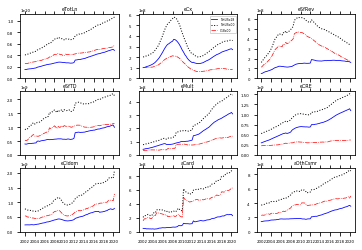

In [86]:
# assumes x18 is second grp, x00 is 1st grp, x31 is third grp:
if len(x3lst) == 3:
  xb = list(bdz3.index)
  plt.rcParams.update({'font.size': 4})

  for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.plot(xb, bdz3[x3lst[0],bcc[i]],c='b',lw=.8,label=x3lst[0][3:])
    plt.plot(xb, bdz3[x3lst[2],bcc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
    plt.plot(xb, bdz3[x3lst[1],bcc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
    plt.ylim(bottom=0)
    plt.title(bcc[i],y=.97)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False) # force sci notation, zero axis!!
    if i==1: lg = plt.legend(loc=0, fontsize=3)

    if i < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      labelbottom=labl) # labels along the bottom edge are off

  plt.savefig(grp+exflg+htyp+'_balhist3.png', dpi=400, bbox_inches='tight')
  plt.show()
else:
  print('skip this section')

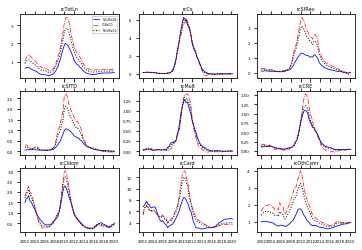

In [87]:
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xb, bdz3[x3lst[0],ncc[i]],c='b',lw=0.8,label=x3lst[0][3:])
  if len(x3lst)>1: plt.plot(xb, bdz3[x3lst[1],ncc[i]],c='r',ls='-.',lw=0.7,label=x3lst[1][3:])
  if len(x3lst)>2: plt.plot(xb, bdz3[x3lst[2],ncc[i]],c='k',ls=':',lw=1,label=x3lst[2][3:])
  plt.title(ncc[i],y=.97)
  if i==0: lg = plt.legend(loc=0, fontsize=3)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_ncohist.png', dpi=400, bbox_inches='tight')
plt.show()

In [88]:
grp

'grpTotUSx18'

In [89]:
grplst

['grpC18x00', 'grpC31x00', 'grpTotUSx00', 'grpTotUSx18', 'grpTotUSx31']

In [90]:
## sections to build stress models for main group: var data in 'hs3' and 'cc3'

In [91]:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

rclst = ['rcTotLn','rcCx','rcSfRev','rcSfTD','rcMult','rcCRE','rcCIdom','rcCard','rcOthCsmr','rcCREtot']
qclst = ['qcTotLn','qcCx','qcSfRev','qcSfTD','qcMult','qcCRE','qcCIdom','qcCard','qcOthCsmr','qcCREtot']

if qtyp == 1:
  curlst = qclst
elif qtyp == 4:
  curlst = rclst
else:
  curlst = []  # force error if qtyp not 1 or 4

#cbon = vtyp

In [92]:
dfc = df2_3z[df2_3z['Grp']==grp]  #  only copy requested groups in "grp"
dfc.dropna(axis=0, how='any', inplace=True)
dfc.head(2)

AsOf          Grp  IDRSSD   nbr         Cert       eTotAst  \
80 2001-12-31  grpTotUSx18       0  8307  150944387.0  2.462050e+09   
81 2002-03-31  grpTotUSx18       0  8244  150071076.0  2.463153e+09   

          eTotLn       eALLL      eOREO         eGW  ...     eTotrb  eALLL_Ln  \
80  1.530361e+09  24474690.0  2176601.0  20575388.0  ...  13.876931  1.599276   
81  1.532394e+09  24696620.0  2331030.0  21424320.0  ...  14.093611  1.611636   

        mxCx    mxSfFst      mxCRE       mxCI    mxCard      mxDDA    eRWA_TA  \
80  6.583113  23.463011  19.673223  15.850377  3.471032  16.446582  70.374394   
81  6.665582  22.974782  20.372491  15.930912  3.055836  15.695436  70.394651   

     lnTotAst  
80  21.624260  
81  21.624708  

[2 rows x 322 columns]

In [93]:
## sUE_CA2 processing
st=''.join(stlst)
hs3.reset_index(drop=False,inplace=True)
hs3.head(2)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
0 2000-03-31    1.5    4.2   7.9  11.5  4.0  4.0  5.5  6.6   6.7  8.3   8.3   
1 2000-06-30    7.5   10.2   4.5   6.4  3.9  3.2  5.7  6.5   6.4  8.6   8.3   

   Prime      DJ    HPI    CRE   VIX        CE  
0    8.7  14.296  102.0  127.0  27.0  5.154105  
1    9.2  13.619  105.0  126.0  33.5  5.136168

In [94]:
## parameters for sUE calcs below (by specified CCAR year):
uex = hs3[['Date','UE']].ix[hs3['UE'].idxmax()]
ccp = cc3[['CCAR','Scen','Date','UE']].iloc[cc3.groupby(['CCAR']).apply(lambda x: x['UE'].idxmax())]

def qtn(d):
  return 4*(d.year - 2000) + d.quarter

uex['qtn'] = qtn(uex['Date'])
ccp['qtn'] = ccp.apply(lambda x: qtn(x['Date']), axis=1)

uep = uex['UE']
ccp['adz'] = uep / ccp['UE']
ccp['que'] = uex['qtn']
ccp['pdt'] = uex['Date']


In [95]:
ccps = []

## parameters for sUE_st calcs below (by specified CCAR year):
if len(stlst)>0:
  UE_st = 'UE_'+''.join(stlst)
  uexs = hs3[['Date',UE_st]].ix[hs3[UE_st].idxmax()]
  ccps = cc3[['CCAR','Scen','Date',UE_st]].iloc[cc3.groupby(['CCAR']).apply(lambda x: x[UE_st].idxmax())]

  uexs['qtn'] = qtn(uexs['Date'])
  ccps['qtn'] = ccps.apply(lambda x: qtn(x['Date']), axis=1)

  ueps = uexs[UE_st]
  ccps['adz'] = ueps / ccps[UE_st]
  ccps['que'] = uexs['qtn']
  ccps['pdt'] = uexs['Date']


In [96]:
ccps

[]

In [97]:
ccp

CCAR Scen       Date     UE  qtn       adz  que        pdt
21   2012  Sev 2013-06-30  13.05   54  0.758621   40 2009-12-31
63   2013  Sev 2014-06-30  12.10   58  0.818182   40 2009-12-31
105  2014  Sev 2015-06-30  11.30   62  0.876106   40 2009-12-31
147  2015  Sev 2016-06-30  10.10   66  0.980198   40 2009-12-31
189  2016  Sev 2017-09-30  10.00   71  0.990000   40 2009-12-31
231  2017  Sev 2018-09-30  10.00   75  0.990000   40 2009-12-31
273  2018  Sev 2019-09-30  10.00   79  0.990000   40 2009-12-31
315  2019  Sev 2020-09-30  10.00   83  0.990000   40 2009-12-31
343  2020  Sev 2021-09-30  10.00   87  0.990000   40 2009-12-31

In [98]:
##########################################################################################
# Date selection for desired CCAR year:
# note:  CCAR 2013 implies stress period (9q) of 2012Q4 thru 2014Q4 (altho' scenario data goes thru 2015Q4)
##########################################################################################

ccar = 2013

if ccar <= 2015:
  dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
else:
  dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
  frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

dtend, frend

(Timestamp('2012-09-30 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [99]:
## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
ccx = cc3[cc3['CCAR'] == ccar]  # ccx contains forecast periods for selected CCAR start year
ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)  ## remove var if not included in CCAR list for this year

hsx = hs3.copy()  ## historical macrovars for this run
hsx.tail(5)

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  Mort  \
75 2018-12-31    1.1    2.9   2.8   4.2  3.8  1.5  2.3  2.9   3.0  4.8   4.8   
76 2019-03-31    3.1    3.9   4.5   4.9  3.9  0.9  2.4  2.5   2.7  4.5   4.4   
77 2019-06-30    2.0    4.7   1.5   3.9  3.6  2.9  2.3  2.1   2.4  4.0   4.0   
78 2019-09-30    2.1    3.8   2.9   4.5  3.6  1.8  2.0  1.7   1.8  3.4   3.7   
79 2019-12-31    2.0    4.0   2.1   4.5  3.5  2.6  1.6  1.6   1.8  3.3   3.7   

    Prime      DJ    HPI    CRE   VIX        CE  
75    5.3  25.725  205.0  280.0  36.1  4.933455  
76    5.5  29.194  206.0  289.0  25.5  4.953490  
77    5.5  30.244  208.0  303.0  20.6  4.967377  
78    5.3  30.442  210.0  311.0  24.6  4.969558  
79    4.8  33.035  212.0  316.0  20.6  4.970738

In [100]:
if vtyp==2:  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccp[ccp['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccp[ccp['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccp[ccp['CCAR']==ccar]['Date'])
  ueinc = (1 - ccp[ccp['CCAR']==ccar]['adz']) / (ccp[ccp['CCAR']==ccar]['qtn'] - ccp[ccp['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE'] = ccx['UE'] * ccx['uead']
  ccx['sUE2'] = ccx['sUE']**2
  if '3' in styp: ccx['sUE3'] = ccx['sUE']**3
  ccx.drop(['uead','sUE'],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE'] = hsx['UE'] * hsx['uead']
  hsx['sUE2'] = hsx['sUE'] ** 2
  if '3' in styp: hsx['sUE3'] = hsx['sUE'] ** 3
  hsx.drop(['uead','sUE'],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE  CPI  T3m  T10y  BBB  \
40  2013  Sev 2015-09-30    4.6    4.1   3.4   3.1  11.4  0.3  0.1   2.2  5.6   
41  2013  Sev 2015-12-31    4.6    4.0   3.1   2.8  11.1  0.3  0.1   2.2  5.4   

    Mort       DJ    HPI    CRE   VIX        CE       sUE2  
40   4.4  13.8544  114.4  162.7  26.3  3.434604  86.998017  
41   4.3  15.2949  115.5  166.0  17.1  3.408205  82.479421

In [101]:
## sUE_st2 & sUE_st3 vars:
if (vtyp==2)&(len(stlst)>0):  # indicates sUE2 and sUE3 vars
  ## cycle thru rows of ccx to calc uead factors for sUE calcs:
  hsx['uead'] = 1.0
  ueadz = ccps[ccps['CCAR']==ccar]['adz']
  uepdt = pd.to_datetime(ccps[ccps['CCAR']==ccar]['pdt'])
  uepdtz = pd.to_datetime(ccps[ccps['CCAR']==ccar]['Date'])
  ueinc = (1 - ccps[ccps['CCAR']==ccar]['adz']) / (ccps[ccps['CCAR']==ccar]['qtn'] - ccps[ccps['CCAR']==ccar]['que'])
  #ueadz, uepdt, uepdtz, ueinc
  uead = 1
  for i in np.arange(len(hsx)):
    if (hsx.loc[i,'Date'] <= uepdt).bool():
      pass
    elif (hsx.loc[i,'Date'] >= uepdtz).bool():
      hsx.loc[i,'uead'] = ueadz.item()
    else:
      uead = uead - ueinc
      hsx.loc[i,'uead'] = uead.item()

  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx = ccx.merge(hsx[['Date','uead']],how='left',on='Date')
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)
  ccx.fillna(method='pad',inplace=True)
  ccx['sUE_'+''.join(stlst)] = ccx[UE_st] * ccx['uead']
  ccx['sUE_'+''.join(stlst)+'2'] = ccx['sUE_'+''.join(stlst)]**2
  if '3' in styp: ccx['sUE_'+''.join(stlst)+'3'] = ccx['sUE_'+''.join(stlst)]**3
  ccx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  ccx.sort_index(by=['CCAR','Scen','Date'],inplace=True)

  hsx['sUE_'+''.join(stlst)] = hsx['UE_'+''.join(stlst)] * hsx['uead']
  hsx['sUE_'+''.join(stlst)+'2'] = hsx['sUE_'+''.join(stlst)] ** 2
  if '3' in styp: hsx['sUE_'+''.join(stlst)+'3'] = hsx['sUE_'+''.join(stlst)] ** 3
  hsx.drop(['uead','sUE_'+''.join(stlst)],axis=1,inplace=True)
  hsx.sort_index(by=['Date'],inplace=True)

ccx.tail(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE  CPI  T3m  T10y  BBB  \
40  2013  Sev 2015-09-30    4.6    4.1   3.4   3.1  11.4  0.3  0.1   2.2  5.6   
41  2013  Sev 2015-12-31    4.6    4.0   3.1   2.8  11.1  0.3  0.1   2.2  5.4   

    Mort       DJ    HPI    CRE   VIX        CE       sUE2  
40   4.4  13.8544  114.4  162.7  26.3  3.434604  86.998017  
41   4.3  15.2949  115.5  166.0  17.1  3.408205  82.479421

In [102]:
## history vars: lag (4q) vars for UE, HPI, CRE:
if vtyp > 0:
  hsx['UE_4'] = hsx['UE'].shift(4)  ## add 4q lag version of UE
  hsx['HPI_4'] = hsx['HPI'].shift(4)
  hsx['CRE_4'] = hsx['CRE'].shift(4)
  hsx['CE_4'] = hsx['CE'].shift(4)

  ccx[['UE_4','HPI_4','CRE_4','CE_4']] = ccx[['UE','HPI','CRE','CE']].shift(4)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-09-30',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-2)+'-12-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-03-31',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-03-31',['UE','HPI','CRE','CE']].values
  ccx.ix[ccx.Date==str(ccar)+'-06-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
        hsx.ix[hsx.Date==str(ccar-1)+'-06-30',['UE','HPI','CRE','CE']].values
  if ccar >= 2016:
    ccx.ix[ccx.Date==str(ccar)+'-09-30',['UE_4','HPI_4','CRE_4','CE_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['UE','HPI','CRE','CE']].values

  if len(stlst)>0: 
    hsx[UE_st +'_4'] = hsx[UE_st].shift(4)  ## add 4q lag version of UE
    hsx['CE_'+''.join(stlst) +'_4'] = hsx['CE_'+''.join(stlst)].shift(4)  ## add 4q lag version of UE
    ccx[UE_st+'_4'] = ccx[UE_st].shift(4)
    ccx['CE_'+''.join(stlst) +'_4'] = ccx['CE_'+''.join(stlst)].shift(4)
    if ccar <= 2015:
      ccx.ix[ccx.Date==str(ccar-1)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-2)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-2)+'-12-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-03-31',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-03-31',[UE_st,'CE_'+''.join(stlst)]].values
    ccx.ix[ccx.Date==str(ccar)+'-06-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-06-30',[UE_st,'CE_'+''.join(stlst)]].values
    if ccar >= 2016:
      ccx.ix[ccx.Date==str(ccar)+'-09-30',[UE_st+'_4','CE_'+''.join(stlst) +'_4']] =\
            hsx.ix[hsx.Date==str(ccar-1)+'-09-30',[UE_st,'CE_'+''.join(stlst)]].values

  ## double check CE, cest, uest vars on boundary date bet hist and forecast (9/30/ccyr-1)
  if ccar <= 2015:
    ccx.ix[ccx.Date==str(ccar-1)+'-09-30',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-09-30',['CE']].values
  else:
    ccx.ix[ccx.Date==str(ccar-1)+'-12-31',['CE']] =\
          hsx.ix[hsx.Date==str(ccar-1)+'-12-31',['CE']].values

#hsx.dropna(how='any', inplace=True)
hsx.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  ...  \
75 2018-12-31    1.1    2.9   2.8   4.2  3.8  1.5  2.3  2.9   3.0  ...   
76 2019-03-31    3.1    3.9   4.5   4.9  3.9  0.9  2.4  2.5   2.7  ...   
77 2019-06-30    2.0    4.7   1.5   3.9  3.6  2.9  2.3  2.1   2.4  ...   
78 2019-09-30    2.1    3.8   2.9   4.5  3.6  1.8  2.0  1.7   1.8  ...   
79 2019-12-31    2.0    4.0   2.1   4.5  3.5  2.6  1.6  1.6   1.8  ...   

        DJ    HPI    CRE   VIX        CE       sUE2  UE_4  HPI_4  CRE_4  \
75  25.725  205.0  280.0  36.1  4.933455   9.666446   4.1  196.0  279.0   
76  29.194  206.0  289.0  25.5  4.953490  10.181901   4.1  199.0  274.0   
77  30.244  208.0  303.0  20.6  4.967377   8.675702   3.9  202.0  288.0   
78  30.442  210.0  311.0  24.6  4.969558   8.675702   3.8  203.0  279.0   
79  33.035  212.0  316.0  20.6  4.970738   8.200413   3.8  205.0  280.0   

        CE_4  
75  4.791392  
76  4.846578  
77  4.881959  
78  4.913323  
79  4.933455  

[5 rows x 23 columns]

In [103]:
ccs = ccx.copy()  # CCAR scenarios for selected year
cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
if 'No' in irflg:
  cccol = [x for x in cccol if x not in xvr] 

Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables

hsx = hsx[['Date']+cccol]  ## align var columns between hist and ccar lists (& remove forecast rows)
hsz = hsx[hsx['Date']<=frend].merge(dfc[['Grp','IDRSSD','AsOf']+curlst],\
                                    how='left',left_on='Date',right_on='AsOf') # merge hs and df data
### remove any rows with missing data:
hsz.dropna(how='any',inplace=True)
hsy = hsz[hsz['Date']<=dtend]  # cut off table at end of history: (ccar_yr-1)-09-30... use this to build models

ccs['Intercept'] = 1.0  # to set up fitting model

hsz['Intercept'] = 1.0   # to set up fitting for all available history

In [104]:
#######################################################
# 12/13/15: added new code for "big3" variables:
#######################################################
cccol3 = []
if ('Big' in irflg)|('big' in irflg):
  for i in np.arange(len(big3)):
    cccol3 = cccol3 + [x for x in cccol if big3[i] in x]
  cccol = cccol3
  Xcol = ['Intercept'] + cccol

cccol = [x for x in cccol if x[-1]!='3']
Xcol = [x for x in Xcol if x[-1]!='3']
Xcol

['Intercept', 'UE', 'sUE2', 'UE_4', 'HPI', 'HPI_4', 'CRE', 'CRE_4']

In [105]:
## model:  du003edb...
## start full model here:

In [106]:
# start full model loop here:
for rc in curlst:
  eqn = rc + " ~ " + " + ".join(cccol)
  yt, Xt = dmatrices(eqn , data=hsy, return_type='dataframe')
  mod = sm.OLS(yt, Xt)
  res_tot = mod.fit()
  pred_tot = res_tot.predict(Xt)
  p_tot = res_tot.predict(ccs[Xcol])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt.rename(columns = {rc : 'Actual'}, inplace=True)
  frt['Fit'] = res_tot.predict(hsz[Xcol])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.rename(columns = {'pred' : 'Base'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'Adverse'}, inplace=True)
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='left',on='Date')
  frt.rename(columns = {'pred' : 'SevAdv'}, inplace=True)
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()
  frt2.columns = [[rc]*len(frt.columns),frt.columns]

  prm = res_tot.params
  prm['rsq'] = res_tot.rsquared
  prm2 = pd.DataFrame(prm)
  prm2.columns = [rc]

  if rc == curlst[0]:
    frt3 = frt2.copy()
    prm3 = prm2.copy()
  else:
    frt3 = frt3.merge(frt2, how='left', left_index=True, right_index=True)
    prm3 = prm3.merge(prm2, how='left', left_index=True, right_index=True)


In [107]:
frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + styp + irflg + ".csv")
prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + styp + irflg + ".csv")
ccar, grp, styp, irflg

(2013, 'grpTotUSx18', 'Lags_sUE2', '_Big3')

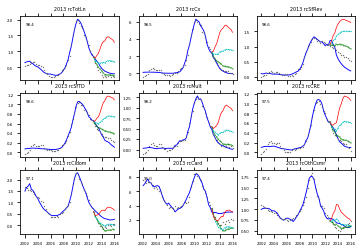

In [108]:
xax = list(frt3.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c')
  plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.title(str(ccar)+" "+curlst[i])
  plt.annotate(str(round(prm3.ix['rsq'][curlst[i]]*100,1)), xy=(0.05, 0.86), xycoords='axes fraction', fontsize=4)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+"_"+str(ccar)+'_full'+str(qtyp) + "q_"+styp+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [109]:
prm3

rcTotLn      rcCx   rcSfRev    rcSfTD    rcMult     rcCRE  \
Intercept  2.346889 -0.153608 -2.009485 -0.424018  0.349137  0.182124   
UE        -0.599585 -1.366140  0.209559 -0.132356 -0.396332 -0.203964   
sUE2       0.053214  0.147515 -0.003036  0.016182  0.036541  0.018687   
UE_4       0.149448  0.592455  0.081645  0.117366  0.152543  0.150828   
HPI       -0.010295 -0.023496 -0.001145 -0.002777 -0.006488 -0.006031   
HPI_4     -0.001213  0.007266 -0.003022 -0.001410  0.001496  0.003154   
CRE        0.002055  0.007019  0.002763  0.001978  0.003591  0.001819   
CRE_4      0.002597  0.010000  0.004883  0.002591  0.000854 -0.000975   
rsq        0.983713  0.985070  0.986317  0.986284  0.982122  0.974729   

            rcCIdom     rcCard  rcOthCsmr  rcCREtot  
Intercept  7.407765  29.388944   2.401507  0.393103  
UE        -1.110701  -4.252647  -0.370929 -0.576925  
sUE2       0.083657   0.288983   0.034300  0.059080  
UE_4       0.099254   0.531703  -0.015602  0.210104  
HPI       -0.018833  -0.059693  -0.004294 -0.009054  
HPI_4     -0.004471  -0.010431  -0.002905  0.001402  
CRE       -0.000090  -0.009077   0.000274  0.003283  
CRE_4      0.001225   0.001942   0.003778  0.003859  
rsq        0.971065   0.949673   0.974213  0.985771

In [110]:
### build 3-var models:

In [111]:
def df1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for rc in curlst:
  for v in cccol:
    y, X = dmatrices( rc + ' ~ ' + v , data=hsy, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)

df1g = df1.groupby(['rc'])
df1t = df1g.apply(df1_topx)
df1t.index = np.arange(len(df1t))

# stores r-sq values for all 2-var combos:
df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs

for idx, row in df1t.iterrows():
  for v in cccol:
    if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
      st2.add(frozenset({row['rc'], v, row['v1']}))

In [112]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = df2.groupby(['rc','v1'], as_index=False)
df2a = grouped.apply(get_topx_2var)
df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
df2a.index = np.arange(len(df2a))

# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df2a.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['rc'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                        'r3': res.rsquared_adj},ignore_index=True)
      st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3']
      cf3 = cf3.append(cm.ix[0])

cf3 = cf3.reset_index(drop=True)
df3 = df3.reset_index(drop=True)
df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)

In [113]:
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

df3g = df3.groupby(['rc','v1','v2'])  #  allows topx for each primary 2-var pair
df3a = df3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
df3a.index.names = ['rci','v1i','v2i','i']
df3ag = df3a.groupby(['rc'])  # prep to find topn best models for each product category
df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
df3b.index = np.arange(len(df3b))

In [114]:
### sections to generate forecasts for all 3-var models:

for idx, row in df3b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] # use this if using top3_rc

  if x == 0:
    frt3b = frt2.copy()
  else:
    frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)

In [115]:
frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt3s.reset_index(drop=False, inplace=True)
frt3s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
#frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn + 1
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.reset_index(drop=True, inplace=True)
frpv.head(8)

scen        rc    Actual    Adverse       Base        Fit     SevAdv      rc2  \
0     rcTotLn0  4.586700  10.924905   6.585856   5.018885  16.079327  rcTotLn   
1     rcTotLn1  4.586700  11.156714   7.015314   5.384262  16.162044  rcTotLn   
2     rcTotLn2  4.586700  10.140386   6.097306   4.839582  15.374472  rcTotLn   
3        rcCx0  7.055552  34.225888  19.580592  13.406110  52.822227     rcCx   
4        rcCx1  7.055552  32.060405  15.762487  10.678871  52.116766     rcCx   
5        rcCx2  7.055552  32.284153  16.739122  10.046346  52.735359     rcCx   
6     rcSfRev0  6.260752  13.533689   9.735468   7.438521  16.935558  rcSfRev   
7     rcSfRev1  6.260752  12.625659   9.525627   7.190365  15.784586  rcSfRev   

scen  ord       diff  rk  
0       0  16.079327   1  
1       0  16.162044   2  
2       0  15.374472   3  
3       1  52.822227   1  
4       1  52.116766   2  
5       1  52.735359   3  
6       2  16.935558   1  
7       2  15.784586   2

In [116]:
df3bc = df3b.copy()
df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df3bc['rc'] = df3bc.index % topn
df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df3bc.reset_index(drop=True, inplace=True)
df3bc.index.names = [grp+"_"+str(ccar)+"_"+styp]
df3bc.tail()

rc2    v1        r1     v2        r2     v3  \
grpTotUSx18_2013_Lags_sUE2                                                      
25                          rcOthCsmr  sUE2  0.627787   UE_4  0.938845  CRE_4   
26                          rcOthCsmr    UE  0.485251   UE_4  0.879251  HPI_4   
27                           rcCREtot  sUE2  0.931835    CRE  0.963382   UE_4   
28                           rcCREtot  sUE2  0.931835  HPI_4  0.957384   UE_4   
29                           rcCREtot  sUE2  0.931835    CRE  0.963382  CRE_4   

                                  r3       Int        c1        c2        c3  \
grpTotUSx18_2013_Lags_sUE2                                                     
25                          0.939630  0.963324  0.015704 -0.114760  0.000470   
26                          0.885037  0.239936  0.238708 -0.152856  0.001162   
27                          0.971241 -1.905627  0.030396  0.004868  0.052237   
28                          0.969946 -1.963385  0.029282  0.006085  0.066376   
29                          0.967053 -1.750054  0.035106  0.007544 -0.002952   

                                    rc  ord  rk  
grpTotUSx18_2013_Lags_sUE2                       
25                          rcOthCsmr1    8   2  
26                          rcOthCsmr2    8   3  
27                           rcCREtot0    9   1  
28                           rcCREtot1    9   2  
29                           rcCREtot2    9   3

In [117]:
frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2013

In [118]:
rnk = 1  ## 1 to topn

df_bst = df3bc[df3bc['rk']== rnk][['rc','v1','v2','v3','r3']]
df_bst.dropna(how='any', inplace=True)
df_bst.reset_index(drop=True, inplace=True)

def vlst(x):
  lst = [x['v1'],x['v2'],x['v3'],str(round(x['r3']*100,1))]
  return ';'.join(lst)

df_bst['var'] = df_bst.apply(vlst, axis=1)
dflst = list(df_bst['var'])
#dflst2 = [dflst[i] for i in grord]
dflst

['sUE2;HPI;HPI_4;95.8',
 'sUE2;CRE;UE_4;97.3',
 'UE;CRE;sUE2;97.7',
 'sUE2;UE_4;CRE_4;97.9',
 'sUE2;CRE;UE_4;95.9',
 'UE_4;sUE2;CRE;95.3',
 'HPI;sUE2;UE;93.9',
 'CRE;sUE2;UE;82.5',
 'sUE2;UE_4;UE;94.0',
 'sUE2;CRE;UE_4;97.1']

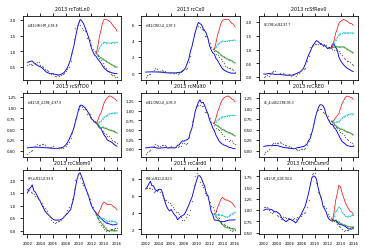

In [119]:
plt.rcParams.update({'font.size': 4})

#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [120]:
grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'.png'

'grpTotUSx18_2013_4q_3v9n_Lags_sUE2_3rk1_Big3.png'

In [121]:
frt3b.ix[:'2012-09-30'][df_bst.ix[i]['rc'],'Actual'][-4:]

Date
2011-12-31    0.850610
2012-03-31    0.791600
2012-06-30    0.771417
2012-09-30    0.787292
Name: (rcOthCsmr0, Actual), dtype: float64

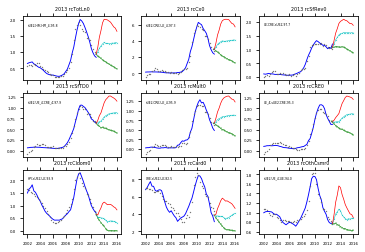

In [122]:
# alt version cuts off act and fit before 1st CCAR forecast period
plt.rcParams.update({'font.size': 4})
xaz=list(frt3b.ix[:str(ccar-1)+'-09-30'].index)
#j = 0

for i in np.arange(len(dflst[0:9])):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xaz,frt3b.ix[:str(ccar-1)+'-09-30'][df_bst.ix[i]['rc'],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Base'],ls='-',lw=.5,marker='+',mew=.25,ms=1.2,c='g')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c')
  plt.plot(xax,frt3b[df_bst.ix[i]['rc'],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dflst[i], xy=(0.05, 0.86), xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.title(str(ccar)+" "+df_bst.ix[i]['rc'])
  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar)+'_'+str(qtyp) + "q"+'_3v9n_'+styp+"_"+str(topn)+'rk'+str(rnk)+irflg+'alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [123]:
df3lst = []
for i in np.arange(len(df3bc)):
  ds = df3bc.ix[i]['v1'] + ', ' + df3bc.ix[i]['v2'] + ', ' + df3bc.ix[i]['v3'] +\
         ': '+ str(round(df3bc.ix[i]['r3']*100,1))
  df3lst = df3lst + [ds]

df3bc['Annot'] = df3lst
df3bc[0:2]

rc2    v1        r1   v2        r2     v3  \
grpTotUSx18_2013_Lags_sUE2                                                  
0                           rcTotLn  sUE2  0.952986  HPI  0.955581  HPI_4   
1                           rcTotLn  sUE2  0.952986  HPI  0.955581    CRE   

                                  r3       Int        c1        c2        c3  \
grpTotUSx18_2013_Lags_sUE2                                                     
0                           0.958332  0.166470  0.020446 -0.004047  0.002252   
1                           0.957348  0.113943  0.020817 -0.003139  0.001284   

                                  rc  ord  rk                   Annot  
grpTotUSx18_2013_Lags_sUE2                                             
0                           rcTotLn0    0   1  sUE2, HPI, HPI_4: 95.8  
1                           rcTotLn1    0   2    sUE2, HPI, CRE: 95.7

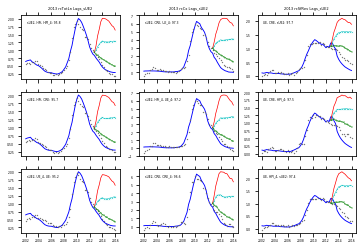

In [124]:
## top3 3-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

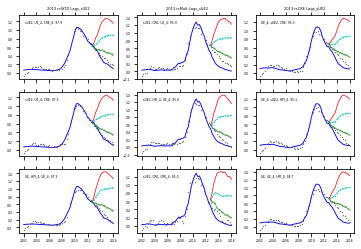

In [125]:
## top3 3-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

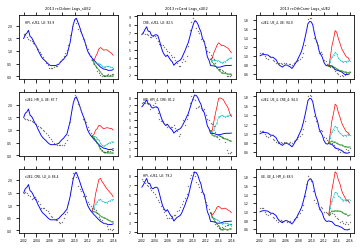

In [126]:
## top3 3-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)
  
plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt3b.index)
  
for rk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rk*3)
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt3b[curlst[i+s3*3]+str(rk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df3bc[df3bc['rc']==curlst[i+s3*3]+str(rk)]['Annot'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
  
    if i+rk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)
  
    if i+rk*3 < 6:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_3v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [127]:
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
df4 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cf4 = pd.DataFrame(columns=['Int','c1','c2','c3','c4'])
st4 = set(frozenset({'rc','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in df3b.iterrows():
  for v in cccol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['rc'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['rc']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v,\
                       data = hsy, return_type='dataframe')
      mod = sm.OLS(y, X)
      res = mod.fit()
      df4 = df4.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                        'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.rsquared_adj},ignore_index=True)
      st4.add(frozenset({row['rc'],v, row['v1'], row['v2'], row['v3']}))
      cm = pd.DataFrame(res.params).T
      cm.columns = ['Int','c1','c2','c3','c4']
      cf4 = cf4.append(cm.ix[0])

cf4 = cf4.reset_index(drop=True)
df4 = df4.reset_index(drop=True)
df4 = df4.merge(cf4, how='inner', left_index=True, right_index=True)

In [128]:
# function to select top 3 for each lead variable:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topx]

def get_topn_4rc(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:topn]

df4g = df4.groupby(['rc','v1','v2','v3'])  #  allows topx for each primary 2-var pair
df4a = df4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
df4a.index.names = ['rci','v1i','v2i','v3i','i']
df4ag = df4a.groupby(['rc'])  # prep to find topn best models for each product category
df4b = df4ag.apply(get_topn_4rc)  # find topn models among all 3-var models
df4b.index = np.arange(len(df4b))

In [129]:
### sections to generate forecasts for all 4-var models:

for idx, row in df4b.iterrows():
  rc = row['rc']
  x = idx
  mdx = idx % topn
  eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=hsy, return_type='dataframe')
  modc = sm.OLS(yc, Xc)
  res_c = modc.fit()
  pred_tot = res_c.predict(hsz[pvar])
  p_tot = res_c.predict(ccs[pvar])  # forecasts
  ccs['pred'] = p_tot
  ## create table holding actual, fitted, and forecasted fail rates
  frt = hsz[['Date', rc]]
  frt['Fit'] = res_c.predict(hsz[pvar])
  frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base']
  frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse']
  frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
  frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
  frt.set_index('Date', drop=True, inplace=True)

  frt2 = frt.copy()

  frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names

  if x == 0:
    frt4b = frt2.copy()
  else:
    frt4b = frt4b.merge(frt2, how='outer', left_index=True, right_index=True)

In [130]:
frt2.head()

rcTotLn2                              
              Actual       Fit Base Adverse SevAdv
Date                                              
2001-12-31  0.647261  0.583839  NaN     NaN    NaN
2002-03-31  0.670497  0.617954  NaN     NaN    NaN
2002-06-30  0.683613  0.624772  NaN     NaN    NaN
2002-09-30  0.696173  0.591621  NaN     NaN    NaN
2002-12-31  0.634826  0.632569  NaN     NaN    NaN

In [131]:
frt4s = pd.DataFrame(frt4b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
frt4s.reset_index(drop=False, inplace=True)
frt4s.columns = ['rc','scen','amt']
frpv = pd.pivot_table(frt4s,index='rc',columns='scen',values='amt')
frpv.reset_index(drop=False, inplace=True)
frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
####################################################################
#   NOTE:  this section will determine ordering of models in charts:
#          3 options: (1) r-sq, (2) SevAdv, or (3) differential bet SevAdv and Base
#frpv['diff'] = frpv['SevAdv']  ## can sort using SevAdv only, or by SevAdv - Base
frpv['diff'] = frpv['SevAdv'] - frpv['Base']  ## SevAdv - Base differential
#frpv['diff'] = frpv.apply(lambda x: x['SevAdv']-max(0,x['Base']),axis=1)
#frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
####################################################################
frpv.sort_index(by=['ord','diff'], ascending=[True,False], inplace=True) # use for diff = SevAdv or SevAdv-Base
#frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
####################################################################
frpv.reset_index(drop=True, inplace=True)
frpv['rk'] = frpv.index % topn
frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
frpv.tail(9)

scen          rc     Actual    Adverse       Base        Fit     SevAdv  \
21       rcCard0  26.984501  21.653043  16.383027  18.276950  36.177794   
23       rcCard1  26.984501   5.607135   8.353796  13.381299  15.763580   
22       rcCard2  26.984501  28.098518  21.541353  23.286217  41.072836   
24    rcOthCsmr0   6.210667   7.769923   5.804793   5.235742  10.755111   
25    rcOthCsmr1   6.210667   9.471091   7.297517   6.403740  12.213953   
26    rcOthCsmr2   6.210667   9.389424   7.229731   6.455455  12.085619   
27     rcCREtot0   3.191417  12.044540   6.031067   4.012302  19.180292   
29     rcCREtot1   3.191417  10.907263   5.910752   3.998149  17.777477   
28     rcCREtot2   3.191417  12.650952   7.383849   5.044340  19.302855   

scen        rc2  ord       diff  rk  
21       rcCard    7  19.794768   0  
23       rcCard    7   7.409784   2  
22       rcCard    7  19.531482   1  
24    rcOthCsmr    8   4.950318   0  
25    rcOthCsmr    8   4.916436   1  
26    rcOthCsmr    8   4.855888   2  
27     rcCREtot    9  13.149225   0  
29     rcCREtot    9  11.866725   2  
28     rcCREtot    9  11.919006   1

In [132]:
df4bc = df4b.copy()
df4bc.rename(columns={'rc' : 'rc2'}, inplace=True)
df4bc['rc'] = df4bc.index % topn
df4bc['rc'] = df4bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
df4bc = df4bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
df4bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
df4bc.reset_index(drop=True, inplace=True)
df4bc['Desc'] = grp+"_"+str(ccar)+"_4v9"+styp
df4bc.tail(9)

rc2    v1        r1     v2        r2     v3        r3     v4  \
21     rcCard   HPI  0.537740   sUE2  0.573175     UE  0.791656  CRE_4   
22     rcCard   HPI  0.537740   sUE2  0.573175     UE  0.791656   UE_4   
23     rcCard   CRE  0.625744   sUE2  0.730864     UE  0.824961    HPI   
24  rcOthCsmr  sUE2  0.627787   UE_4  0.938845     UE  0.939925    HPI   
25  rcOthCsmr  sUE2  0.627787   UE_4  0.938845  CRE_4  0.939630    HPI   
26  rcOthCsmr  sUE2  0.627787   UE_4  0.938845  CRE_4  0.939630    CRE   
27   rcCREtot  sUE2  0.931835  HPI_4  0.957384   UE_4  0.969946    HPI   
28   rcCREtot  sUE2  0.931835    CRE  0.963382   UE_4  0.971241     UE   
29   rcCREtot  sUE2  0.931835    CRE  0.963382   UE_4  0.971241    HPI   

          r4        Int        c1        c2        c3        c4          rc  \
21  0.920658  24.828120 -0.047867  0.229410 -2.824616 -0.019734     rcCard0   
22  0.915935  32.425732 -0.085016  0.331742 -5.026874  0.712446     rcCard1   
23  0.895056  21.594693 -0.023514  0.168178 -2.115026 -0.034340     rcCard2   
24  0.944062   1.697906  0.024489 -0.094159 -0.142082 -0.001546  rcOthCsmr0   
25  0.941735   1.069603  0.014712 -0.109209  0.000885 -0.001127  rcOthCsmr1   
26  0.941108   0.968064  0.013757 -0.098756  0.001999 -0.001596  rcOthCsmr2   
27  0.975234  -1.648283  0.026712  0.009582  0.081514 -0.005387   rcCREtot0   
28  0.972474  -1.508227  0.039470  0.004687  0.077354 -0.140536   rcCREtot1   
29  0.971269  -1.777513  0.029801  0.005500  0.053939 -0.001500   rcCREtot2   

    ord  rk                           Desc  
21    7   0  grpTotUSx18_2013_4v9Lags_sUE2  
22    7   2  grpTotUSx18_2013_4v9Lags_sUE2  
23    7   1  grpTotUSx18_2013_4v9Lags_sUE2  
24    8   0  grpTotUSx18_2013_4v9Lags_sUE2  
25    8   1  grpTotUSx18_2013_4v9Lags_sUE2  
26    8   2  grpTotUSx18_2013_4v9Lags_sUE2  
27    9   0  grpTotUSx18_2013_4v9Lags_sUE2  
28    9   2  grpTotUSx18_2013_4v9Lags_sUE2  
29    9   1  grpTotUSx18_2013_4v9Lags_sUE2

In [133]:
frt4b.to_csv(grp + "_"  + str(ccar) +'_4v_9fcst_' + str(qtyp) + "q_" + styp +irflg + '.csv')
df4bc.to_csv(grp + "_"  + str(ccar) + '_4v_9param_' + str(qtyp) + "q_" + styp +irflg + '.csv')
ccar

2013

In [134]:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(df4bc)):
  ds1 = df4bc.ix[i]['v1'] + ', ' + df4bc.ix[i]['v2'] + ', ' + df4bc.ix[i]['v3'] + ','
  ds2 = df4bc.ix[i]['v4'] +': '+ str(round(df4bc.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

df4bc['Annot1'] = df4lst1
df4bc['Annot2'] = df4lst2
df4bc[0:2]

rc2    v1        r1    v2        r2     v3        r3     v4        r4  \
0  rcTotLn  sUE2  0.952986  UE_4  0.952059     UE  0.951797    HPI  0.963453   
1  rcTotLn  sUE2  0.952986   HPI  0.955581  HPI_4  0.958332  CRE_4  0.961155   

        Int        c1        c2        c3        c4        rc  ord  rk  \
0  1.306523  0.038288  0.060877 -0.294118 -0.004321  rcTotLn0    0   2   
1  0.269015  0.021192 -0.006486  0.006905 -0.002572  rcTotLn1    0   0   

                            Desc             Annot1       Annot2  
0  grpTotUSx18_2013_4v9Lags_sUE2    sUE2, UE_4, UE,    HPI: 96.3  
1  grpTotUSx18_2013_4v9Lags_sUE2  sUE2, HPI, HPI_4,  CRE_4: 96.1

In [135]:
##################################################################################
# select highest R-squared model:
#md = [0,0,0,0,0,0,0,0,0]  # note: use this to rank based on R-squared
#mdr = [x for x in list(df4bc['rc']) if x[-1]=='0']

# special code to select "best" model based on max 9q diff between SevAdv and Base forecasts:
md=list(df4bc[df4bc['rk']==0]['rc'])  # note: use this if you want models based on diff calc (SevAdv - Bas ranking)
mdr = [x[-1] for x in md]

mdr, md

(['1', '0', '1', '1', '0', '0', '1', '0', '0', '0'],
 ['rcTotLn1',
  'rcCx0',
  'rcSfRev1',
  'rcSfTD1',
  'rcMult0',
  'rcCRE0',
  'rcCIdom1',
  'rcCard0',
  'rcOthCsmr0',
  'rcCREtot0'])

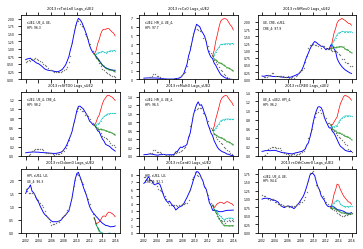

In [136]:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

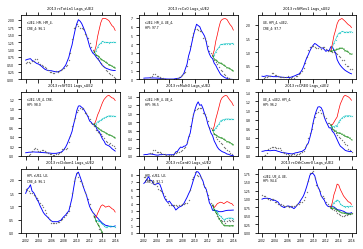

In [137]:
## special version for TotUSx18 only... best version based on diff bet SevAdv and Base:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

#ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'.png', dpi=400, bbox_inches='tight')
plt.show()

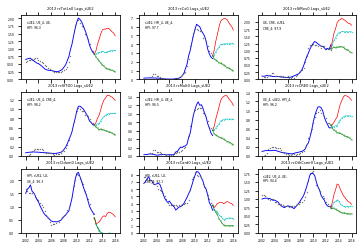

In [138]:
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

ver = 0     ## 0, 1, 2 only
for i in np.arange(9):
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

  plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_'+str(ver)+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

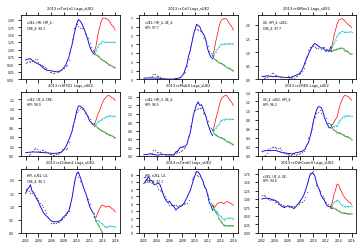

In [139]:
## special version for 2013 TotUSx18 only... best diff sevadv - base (9q only)
# alt cuts off act and fit before forecast starts:
plt.rcParams.update({'font.size': 3})
xax = list(frt4b.index)

for i in np.arange(9):
  ver = mdr[i]
  plt.subplot(3, 3, i+1)
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Actual'],ls='-',c='b',lw=.9,label='History')
  plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i]+str(ver),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
  plt.plot(xax,frt4b[curlst[i]+str(ver),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot1'].values[0], xy=(0.06, 0.88),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.annotate(df4bc[df4bc['rc']==curlst[i]+str(ver)]['Annot2'].values[0], xy=(0.06, 0.80),\
               xycoords='axes fraction', fontsize=3) # var listing annotation
  plt.ylim(bottom=0)

  plt.title(str(ccar)+" "+curlst[i]+str(ver)+" "+styp)

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v9n_'+styp+'_bestdiff'+irflg +'alt.png', dpi=400, bbox_inches='tight')
plt.show()

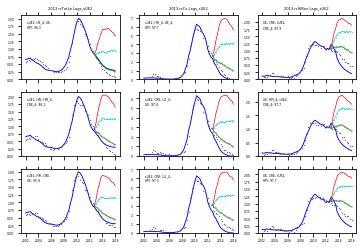

In [140]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

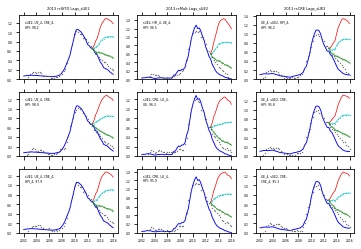

In [141]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

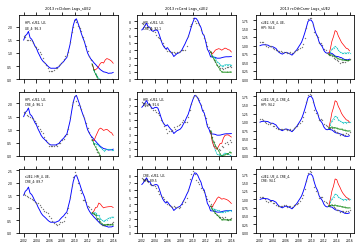

In [142]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off

    plt.ylim(bottom=0)

plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [143]:
## repeat triple charts cutting off actual and fitted to prior Sept (9/30/2012 for 2013 CCAR)

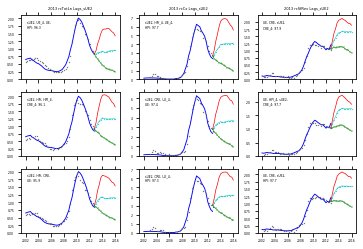

In [144]:
## top3 4-var models for sets of 3 products"
s3 = 0     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(bottom=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

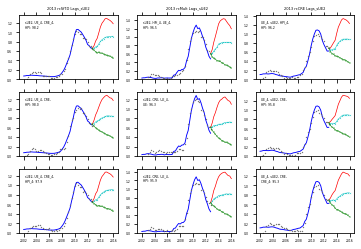

In [145]:
## top3 4-var models for sets of 3 products"
s3 = 1     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(bottom=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

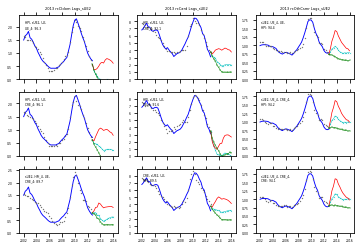

In [146]:
## top3 4-var models for sets of 3 products"
s3 = 2     ## 0, 1, 2 only (which 3 prods to show)

plt.rcParams.update({'font.size': 3})
s3d = dict(zip([0,1,2],['a','b','c']))
xax = list(frt4b.index)

for rnk in [0,1,2]:
  for i in np.arange(3):
    plt.subplot(3, 3, i+1+rnk*3)
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Actual'],ls='-',c='b',lw=.9,label='History')
    plt.plot(xaz,frt4b.ix[:str(ccar-1)+'-09-30'][curlst[i+s3*3]+str(rnk),'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1,label='Fitted')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Adverse'],ls='-',lw=.5,marker='x',mew=.25,ms=1.2,c='c',label='Adverse')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
    plt.plot(xax,frt4b[curlst[i+s3*3]+str(rnk),'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot1'].values[0], xy=(0.06, 0.88),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.annotate(df4bc[df4bc['rc']==curlst[i+s3*3]+str(rnk)]['Annot2'].values[0], xy=(0.06, 0.80),\
                 xycoords='axes fraction', fontsize=3) # var listing annotation
    plt.ylim(bottom=0)

    if i+rnk*3 < 3:
      plt.title(str(ccar)+" "+curlst[i+s3*3]+" "+styp)

    if i+rnk*3 < 6:
      labl = False
    else:
      labl = True

    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off


plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_4v27n'+s3d[s3]+'_'+styp+irflg +'alt.png',\
            dpi=400, bbox_inches='tight')
plt.show()

In [147]:
## section to calculate volumes of NCOs from the forecasted NCO rates:

In [148]:
nmlst = ['qncTotLn','qncCx','qncSfRev','qncSfTD','qncMult','qncCRE','qncCIdom','qncCard','qncOthCsmr','qncCREtot'] # numerators in vofi
dmlst = ['eTotLn','eCx','eSfRev','eSfTD','eMult','eCRE','eCIdom','aCard','aOthCsmr','eCREtot'] # denominators in vofi

nmz = dict(zip(rclst, nmlst))
dmz = dict(zip(rclst, dmlst))

#col names to use:
fv = "Fv"  # Fitted model volumes
bv = "Bv"  # Base scenario volumes
av = "Av"  # Adverse scenario volumes
sv = "Sv"  # SevAdv scenario volumes
fm = "Fit"  # these last 4 are model outputs for fitted model & 3 scenarios
bm = "Base"
am = "Adverse"
svm = "SevAdv"  ######### changed on 12/8/15 from sm to svm to avoid statsmodels abbreviation

In [149]:
## volumes file:
vofi = "df2_3z_"+grp+".csv"            ## history volumes file for groups to analyze
vo = pd.read_csv(vofi, index_col=0)
vo = vo[vo['Grp']==grp]
vo.rename(columns={"AsOf":"Date"}, inplace=True)
vo['Date'] = pd.to_datetime(vo['Date'])
vo.set_index('Date',drop=True,inplace=True)

dfz1 = []
dfz3 = []

In [150]:
#vv = 2  ## 0,1,2 only:  selects vlst item

#mn = 1 # single models per rc ("full" files)
#mn = 3 # 3 vars per rc ("3v" files)
mn = 4 # 4 vars per rc ("4v" files)

#rkfi = pd.read_csv(grp+'_allyr_' + str(rtyp) +'_'+str(mn)+'v10best_'+cbo[vv]+'.csv', index_col=0)
#rkfi.set_index('ccar',drop=True, inplace=True)

In [151]:
if ccar <= 2015:
  dttr = str(ccar-1) + "-09-30"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar-1) + "-12-31"  # start of 9q forecast period
  dten = str(ccar+1) + "-12-31"  # end of 9q forecast period
else:
  dttr = str(ccar-1) + "-12-31"  # transition date (3rd qtr of year prior to CCAR year)
  dtst = str(ccar) + "-03-31"  # start of 9q forecast period
  dten = str(ccar+2) + "-03-31"  # end of 9q forecast period

if ccar >= 2016: 
  vo = vo.ix[:dttr]  # special handling for CCAR years after 2015
else:
  vo = vo.ix[:"2014-12-31"]  # conforms to book exhibits

if mn == 1:
  mtyp = '_full_'
elif mn == 3:
  mtyp = '_3v_'
elif mn == 4:
  mtyp = '_4v_'
else:
  mtyp = 'xxx'  # force error to fix problem
  
hdrw = [0,1] # indicates first 2 rows in forecast file "rtfi" have col headings
  
rtfi = grp + "_" + str(ccar) + mtyp + "9fcst_" + rtyp +"_" + styp +irflg + ".csv" ## file with modeled ccar forecast nco/fail rates
rt = pd.read_csv(rtfi, index_col=0, header=hdrw, parse_dates=True)
  
paramfi = grp + "_" + str(ccar) + mtyp + "9param_" + rtyp +"_"  + styp +irflg + ".csv"  ## param file for same run
param = pd.read_csv(paramfi, index_col=0, header=0)
param.index.name= 'scen'
  
### start prod loops here:
balst= []
dmlst = []

In [152]:
param.head(2)

rc2    v1        r1    v2        r2     v3        r3     v4  \
scen                                                                    
0     rcTotLn  sUE2  0.952986  UE_4  0.952059     UE  0.951797    HPI   
1     rcTotLn  sUE2  0.952986   HPI  0.955581  HPI_4  0.958332  CRE_4   

            r4       Int        c1        c2        c3        c4        rc  \
scen                                                                         
0     0.963453  1.306523  0.038288  0.060877 -0.294118 -0.004321  rcTotLn0   
1     0.961155  0.269015  0.021192 -0.006486  0.006905 -0.002572  rcTotLn1   

      ord  rk                           Desc  
scen                                          
0       0   2  grpTotUSx18_2013_4v9Lags_sUE2  
1       0   0  grpTotUSx18_2013_4v9Lags_sUE2

In [153]:
for pr in np.arange(len(rt.columns.levels[0])):
  if mn > 1:
    prn = rclst[int(pr/topn)]+str(pr % topn)  # add rank suffix to prodname
  else:
    prn = rclst[int(pr/topn)]    ## just use prodname
  prnm = rclst[int(pr/topn)]     ## prod name (no rank suffix)
  drt = rt[prn]
  df = vo[[nmz[prnm],dmz[prnm]]]
  df.columns = ['nco','bal']
  
  dfr = df.merge(drt, how='outer', left_index=True, right_index=True)
  
  # seed early rows of vol cols with actuals, then calc model vols for forecast periods:
  dfr['Fv'] = dfr['nco']  # added 12/12
  dfr['Bv'] = dfr['nco']
  dfr['Av'] = dfr['nco']
  dfr['Sv'] = dfr['nco']
  
  dfr['bal'] = dfr['bal'].fillna(method='pad')
  dfr[[bm,am,svm]] = dfr[[bm,am,svm]].fillna(-999)
  
  dfr.ix[dttr][bm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][bm] == -999:
      dfr.ix[x][bv] = dfr.ix[x].nco
      dfr.ix[x][fv] = dfr.ix[x].nco # added 12/12
    else:
      if rtyp == "4q":
        dfr.ix[x][bv] = dfr.ix[x][bm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][bv] +dfr.ix[x-2][bv] +dfr.ix[x-3][bv])
        dfr.ix[x][fv] = dfr.ix[x][fm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][fv] +dfr.ix[x-2][fv] +dfr.ix[x-3][fv])  # added 12/12
      else:
        dfr.ix[x][bv] = dfr.ix[x][bm] * dfr.ix[x].bal/400 
        dfr.ix[x][fv] = dfr.ix[x][fm] * dfr.ix[x].bal/400  # added 12/12
  
  dfr.ix[dttr][am] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][am] == -999:
      dfr.ix[x][av] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][av] = dfr.ix[x][am] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][av] +dfr.ix[x-2][av] +dfr.ix[x-3][av])
      else:
        dfr.ix[x][av] = dfr.ix[x][am] * dfr.ix[x].bal/400 
  
  dfr.ix[dttr][svm] = -999
  for x in np.arange(len(dfr))[rskp:]:
    if dfr.ix[x][svm] == -999:
      dfr.ix[x][sv] = dfr.ix[x].nco
    else:
      if rtyp == "4q":
        dfr.ix[x][sv] = dfr.ix[x][svm] * (dfr.ix[x].bal+dfr.ix[x-1].bal+dfr.ix[x-2].bal+dfr.ix[x-3].bal)/400 -\
          (dfr.ix[x-1][sv] +dfr.ix[x-2][sv] +dfr.ix[x-3][sv])
      else:
        dfr.ix[x][sv] = dfr.ix[x][svm] * dfr.ix[x].bal/400 
  
  ## NEW SECTION:
  dfr.replace(to_replace=-999, value=np.nan, inplace=True)  ## replace -999 with nan
  for i in np.arange(len(dfr)):     ## remove forecast Adverse vol if there is no Adverse scenario
    if dfr.iloc[i].name >= pd.to_datetime(dtst):  ## check that this is a forecast period, not history
      if np.isnan(dfr.ix[i]['Adverse']):
        dfr.ix[i]['Av'] = np.nan
  
  dfv = dfr[['Bv','Av','Sv']].ix[dtst:dten].sum()  # 9q forecasts (ignore nco, Fv) 
  
  r9q = dfr['2006-12-31':dtst]['nco'].rolling(9, min_periods=9).sum()
  r9q = r9q.dropna()
  r9qm = r9q[r9q==r9q.max()]  # largest 9q losses in history
  
  dfv2 = pd.DataFrame(dfv, columns=[prn])
  dfv2.ix['ActMx'] = r9qm.values[0]
  dfv2.ix['DateMx'] = r9qm.index[0]
  dfv2t = dfv2.T
  dfv2t.reset_index(drop=False, inplace=True)
  
  b9q = dfr['2006-12-31':dtst]['bal'].rolling(9, min_periods=9).mean()
  balst = balst + [b9q.ix[r9qm.index[0]]]  ## avg bal for max actual charge-offs
  
  dmlst = dmlst + [dfr['bal'].ix[dtst:dten].mean()]  ## avg bal during CCAR periods
#  voldet = dfr.ix[str(ccar-1)+'-01-01':]
  voldet = dfr.ix[str(ccar-3)+'-01-01':]
  voldet.columns = pd.MultiIndex.from_product([[prn], list(voldet.columns)])
  
  if pr == 0:
    dfvr = dfv2t
    voldet2 = voldet.copy()
  else:
    dfvr = pd.concat([dfvr, dfv2t],ignore_index=True)
#    voldet2 = voldet2.merge(voldet, how='left', left_index=True, right_index=True)
    voldet2 = pd.concat([voldet,voldet2],ignore_index=True,axis=1)

In [154]:
dfvr.head(2)

index           Bv           Av           Sv        ActMx     DateMx
0  rcTotLn0   3.2148e+07   7.1721e+07  1.26113e+08  1.10488e+08 2010-12-31
1  rcTotLn1  4.75807e+07  9.99912e+07  1.57227e+08  1.10488e+08 2010-12-31

In [155]:
if mn > 1:
  dfvr2 = dfvr.copy()
  dfvr2['bal'] = dmlst
  dfvr2['ActBalMx'] = balst
  dfvr2['rk']  = dfvr2.index % mn
  dfvr2['rk'] += 1
  
  dfvr2t = dfvr2.copy()
  dfvr2t['ActMxRt'] = dfvr2t['ActMx']*100/(dfvr2t['ActBalMx']+.000001)
  dfvr2t['ModRt'] = dfvr2t['Sv']*100/(dfvr2t['bal']+.000001)
  dfvr2t = dfvr2t[['index','bal','Bv','Av','Sv','ActMx','ActBalMx','DateMx','ActMxRt','ModRt']] # chgd 12/12 'Fv'
  dfvr2t['Diff'] = dfvr2t['Sv'] - dfvr2t['Bv']
  dfvr2t['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp + styp
  dfvr2t.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_vol.csv")
  voldet2.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg+ "_voldet.csv")
  dfz3 = dfvr2t.copy()
  
if mn == 1:
  dfvr['bal'] = dmlst
  dfvr['ActBalMx'] = balst
  dfvr[['Bv','Av','Sv','ActMx']] = dfvr[['Bv','Av','Sv','ActMx']].astype(float)
  
  dfvrt = dfvr.copy()
  dfvrt['ActMxRt'] = dfvrt['ActMx']*100/dfvrt['ActBalMx']
  dfvrt['ModRt'] = dfvrt['Sv']*100/dfvrt['bal']
  dfvrt['Diff'] = dfvrt['Sv'] - dfvrt['Bv']
  dfvrt['Desc'] = grp+"_"+str(ccar) + mtyp + rtyp +"_"+ styp
  dfvrt.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv")
  voldet.to_csv(grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_voldet.csv")
  dfz1 = dfvrt.copy()

In [156]:
voldet.tail()

rcCREtot2                                                        \
                 nco           bal    Actual       Fit      Base   Adverse   
Date                                                                         
2014-12-31  326980.0  1.193981e+09  0.110968  0.242341  0.635919  1.469146   
2015-03-31       NaN  1.193981e+09  0.088718  0.260871  0.614942  1.486944   
2015-06-30       NaN  1.193981e+09  0.077400  0.231158  0.588570  1.472837   
2015-09-30       NaN  1.193981e+09  0.068848  0.169423  0.535666  1.493934   
2015-12-31       NaN  1.193981e+09  0.065535  0.124698  0.505497  1.481182   

                                                                              
              SevAdv            Fv            Bv            Av            Sv  
Date                                                                          
2014-12-31  2.385798  1.903408e+06  4.097145e+06  7.826854e+06  1.095948e+07  
2015-03-31  2.294881  4.404611e+05  1.249526e+06  3.761787e+06  5.721725e+06  
2015-06-30  2.208760 -3.408311e+05  6.301590e+05  2.952939e+06  4.244889e+06  
2015-09-30  2.185634  1.984292e+04  4.189195e+05  3.295712e+06  5.169969e+06  
2015-12-31  2.062083  1.369397e+06  3.736931e+06  7.674604e+06  9.484308e+06

In [157]:
grp + "_" + str(ccar) + mtyp + rtyp +"_"+ styp +irflg + "_vol.csv"

'grpTotUSx18_2013_4v_4q_Lags_sUE2_Big3_vol.csv'

In [158]:
grp = grporig  # reset to original grp designation
grp, styp, irflg, ccar

('grpTotUSx18', 'Lags_sUE2', '_Big3', 2013)